In [5]:
library(lubridate)
#library(MASS)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [6]:
DATA_DIR = '../data/clean/'

In [7]:
files <- list.files(DATA_DIR)
# missing temp data
files <- files[-which(grepl('mountRushmoreSD', files))] 
files <- files[-which(grepl('rosaliaWA', files))]
files[1:5]
length(files)

[1] "alpineMeadowsWA.csv_2007.csv" "alpineMeadowsWA.csv_2008.csv"
[3] "alpineMeadowsWA.csv_2009.csv" "alpineMeadowsWA.csv_2010.csv"
[5] "alpineMeadowsWA.csv_2011.csv"

[1] 230

In [8]:
prep.data <- function(path) {
  daily <- read.csv(path)
  daily$DATE <- as.Date(daily$DATE, format='%Y-%m-%d')
  daily <- daily[complete.cases(daily), ]
  daily <- daily[order(daily$DATE), ]
  daily$MONTH <- as.numeric(format(daily$DATE, '%m'))
  daily$YDAY <- yday(daily$DATE)
  daily$TAVG[daily$TAVG > 57 | daily$TAVG < -63] <- NA
  daily$TMIN[daily$TMIN > 57 | daily$TMIN < -63] <- NA
  daily$TMAX[daily$TMAX > 57 | daily$TMAX < -63] <- NA
  monthly.means <- tapply(daily$TAVG, daily$MONTH, mean)
  daily$monthly.means <- monthly.means[daily$MONTH]
  monthly.precip <- tapply(daily$PRCP, daily$MONTH, sum)
  daily$monthly.precip <- monthly.precip[daily$MONTH]
  daily
}

In [9]:
data <- prep.data(paste(DATA_DIR, files[1], sep=''))

for (i in 2:length(files)) {
  tmp <- prep.data(paste(DATA_DIR, files[i], sep=''))
  data <- rbind(data, tmp)
}

In [10]:
dim(data)
head(data)

[1] 86794    15

STATION     NAME                  LATITUDE LONGITUDE ELEVATION DATE      
1 USS0021B48S ALPINE MEADOWS, WA US 47.78    -121.7    1066.8    2007-01-01
2 USS0021B48S ALPINE MEADOWS, WA US 47.78    -121.7    1066.8    2007-01-02
3 USS0021B48S ALPINE MEADOWS, WA US 47.78    -121.7    1066.8    2007-01-03
4 USS0021B48S ALPINE MEADOWS, WA US 47.78    -121.7    1066.8    2007-01-04
5 USS0021B48S ALPINE MEADOWS, WA US 47.78    -121.7    1066.8    2007-01-05
6 USS0021B48S ALPINE MEADOWS, WA US 47.78    -121.7    1066.8    2007-01-06
  PRCP TAVG TMAX TMIN YEAR MONTH YDAY monthly.means monthly.precip
1 38.1  2.3  5.3  0.0 2007 1     1    2.775558e-17  579.1         
2 66.0  4.4  6.5  2.5 2007 1     2    2.775558e-17  579.1         
3 61.0  1.2  2.5 -0.6 2007 1     3    2.775558e-17  579.1         
4 30.5 -1.9 -0.2 -3.4 2007 1     4    2.775558e-17  579.1         
5  0.0 -1.6  0.3 -4.2 2007 1     5    2.775558e-17  579.1         
6  5.1 -1.4  0.5 -2.4 2007 1     6    2.775558e-17  579.1

In [11]:
predict.daily <- function(daily, statistic) {
  DAYS <- 365.25
  mod <- lm(daily[, statistic] ~ monthly.means 
              + YDAY
              + monthly.precip
              + monthly.precip:monthly.means
              + monthly.precip:YDAY
              + monthly.precip:I(YDAY^2)
              + I(YDAY^2)
              + YDAY:monthly.means
              + I(YDAY^2):monthly.means
              + sin(pi*(YDAY - DAYS/4 - 30) / (DAYS/2)),
            data=daily)
  mod <- step(mod, trace=0)
  mod
}


Call:
lm(formula = daily[, statistic] ~ monthly.means + YDAY + monthly.precip + 
    monthly.precip:monthly.means + monthly.precip:YDAY + monthly.precip:I(YDAY^2) + 
    I(YDAY^2) + YDAY:monthly.means + I(YDAY^2):monthly.means + 
    sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2)), data = daily)

Residuals:
     Min       1Q   Median       3Q      Max 
-21.5381  -2.1448   0.1594   2.3270  20.0190 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              2.360e+00  1.510e-01  15.629  < 2e-16
monthly.means                            1.049e+00  1.150e-02  91.246  < 2e-16
YDAY                                    -1.958e-02  1.853e-03 -10.564  < 2e-16
monthly.precip                          -1.066e-03  3.288e-04  -3.242  0.00119
I(YDAY^2)                                4.150e-05  4.545e-06   9.130  < 2e-16
sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2))  2.103e+00  8.185e-02  25.698  < 2e-16
monthly.means:monthly.precip          

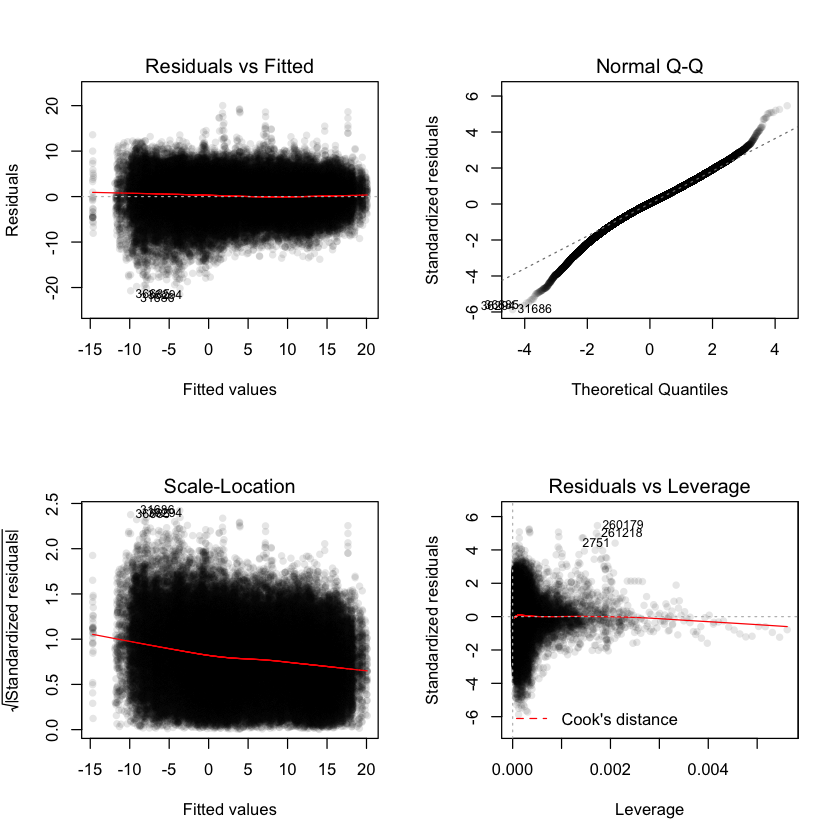

In [12]:
mean.temp.mod <- predict.daily(data, 'TAVG')
summary(mean.temp.mod)
par(mfrow=c(2, 2))
plot(mean.temp.mod, pch=16, col=rgb(0, 0, 0, 0.1))

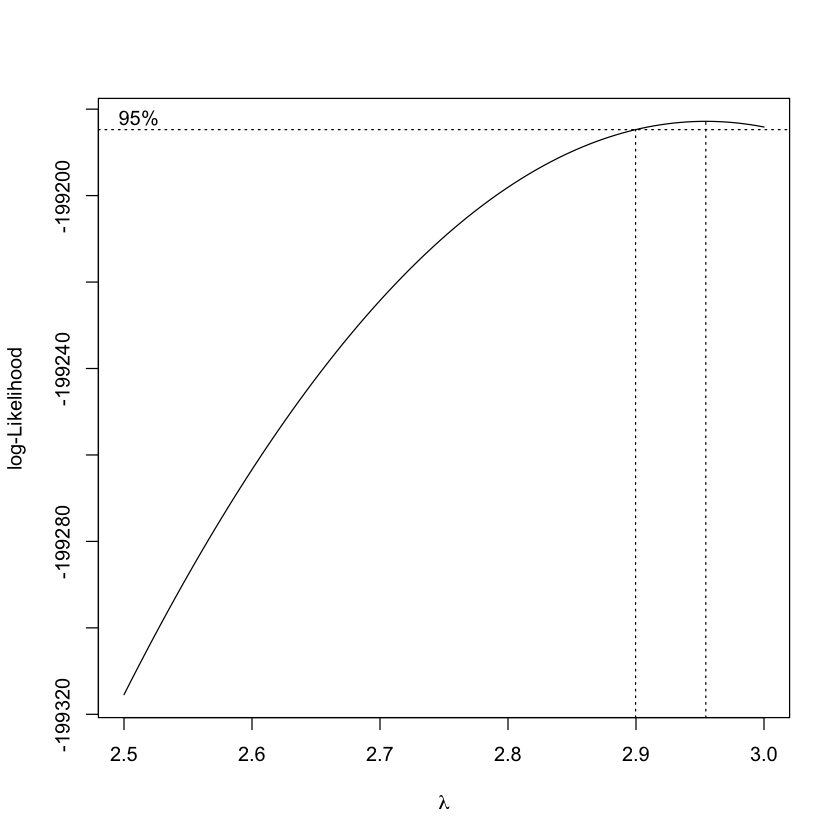

In [13]:
DAYS <- 365.25
mean.temp.mod <- lm(TAVG + 100 ~ monthly.means
                      + YDAY
                      + monthly.precip
                      + monthly.precip:monthly.means 
                      + monthly.precip:YDAY 
                      + monthly.precip:I(YDAY^2) 
                      + I(YDAY^2) 
                      + YDAY:monthly.means 
                      + I(YDAY^2):monthly.means 
                      + sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2)), 
                    data=data)
boxcox(mean.temp.mod, lambda=seq(2.5, 3, length=20))


Call:
lm(formula = tavg + 100 ~ monthly.means + YDAY + monthly.precip + 
    monthly.precip:monthly.means + monthly.precip:YDAY + monthly.precip:I(YDAY^2) + 
    I(YDAY^2) + YDAY:monthly.means + I(YDAY^2):monthly.means + 
    sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2)), data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-125784  -19471     374   19550  238685 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              2.839e+05  1.269e+03 223.828  < 2e-16
monthly.means                            6.819e+03  9.657e+01  70.614  < 2e-16
YDAY                                    -1.256e+02  1.557e+01  -8.065 7.39e-16
monthly.precip                          -5.200e+00  2.762e+00  -1.883   0.0597
I(YDAY^2)                                2.823e-01  3.818e-02   7.393 1.45e-13
sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2))  1.317e+04  6.876e+02  19.155  < 2e-16
monthly.means:monthly.precip            -3.228e+00  2.757

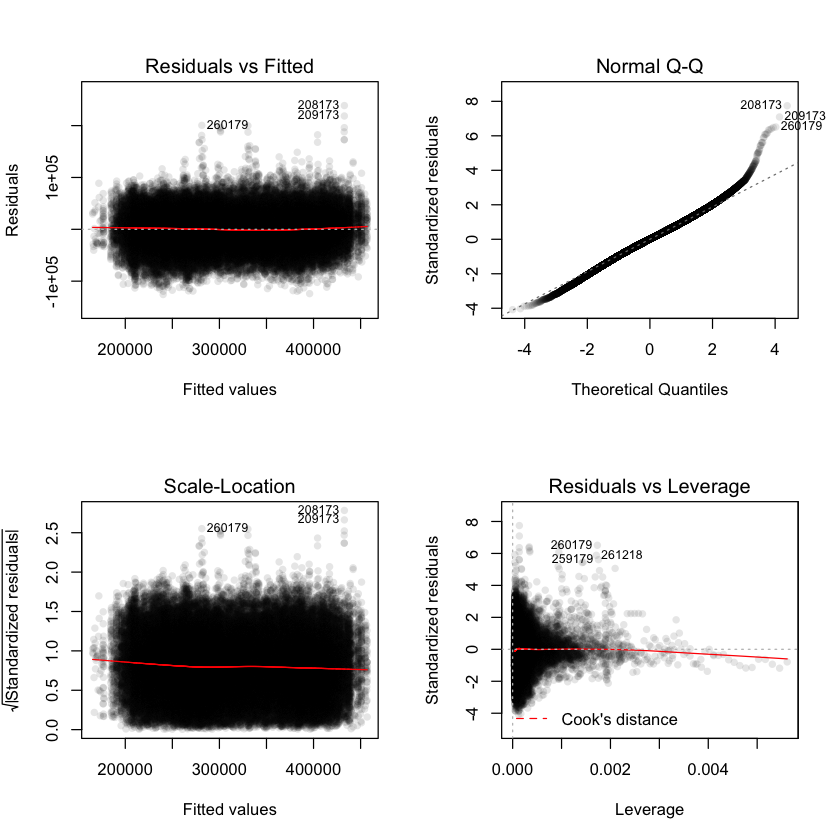

In [29]:
lambda.avg <- 2.95
data$tavg <- ((data$TAVG + 100)^lambda.avg - 1) / lambda.avg
mean.temp.mod <- lm(tavg + 100 ~ monthly.means
                      + YDAY
                      + monthly.precip
                      + monthly.precip:monthly.means 
                      + monthly.precip:YDAY 
                      + monthly.precip:I(YDAY^2) 
                      + I(YDAY^2) 
                      + YDAY:monthly.means 
                      + I(YDAY^2):monthly.means 
                      + sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2)), 
                    data=data)
summary(mean.temp.mod)
par(mfrow=c(2, 2))
plot(mean.temp.mod, pch=16, col=rgb(0, 0, 0, 0.1))

In [15]:
which(rownames(data) == 19389)

[1] 36343

In [16]:
data[36343, ]

STATION     NAME                 LATITUDE LONGITUDE ELEVATION DATE      
19389 USS0021A35S HOZOMEEN CAMP, WA US 48.98    -121.08   515.1     2007-07-12
      PRCP TAVG TMAX TMIN  YEAR MONTH YDAY monthly.means monthly.precip
19389 0    28.1 38.1 -14.5 2007 7     193  20.12581      15.2          
      tavg    
19389 559046.1


Call:
lm(formula = daily[, statistic] ~ monthly.means + YDAY + monthly.precip + 
    monthly.precip:monthly.means + monthly.precip:YDAY + monthly.precip:I(YDAY^2) + 
    I(YDAY^2) + YDAY:monthly.means + I(YDAY^2):monthly.means + 
    sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2)), data = daily)

Residuals:
     Min       1Q   Median       3Q      Max 
-23.3706  -2.3635   0.1725   2.6282  20.6637 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                             -1.472e+00  1.717e-01  -8.569  < 2e-16
monthly.means                            1.313e+00  1.307e-02 100.456  < 2e-16
YDAY                                    -5.250e-02  2.107e-03 -24.914  < 2e-16
monthly.precip                           2.575e-03  3.739e-04   6.888 5.71e-12
I(YDAY^2)                                1.337e-04  5.168e-06  25.873  < 2e-16
sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2))  1.955e+00  9.308e-02  21.008  < 2e-16
monthly.means:monthly.precip          

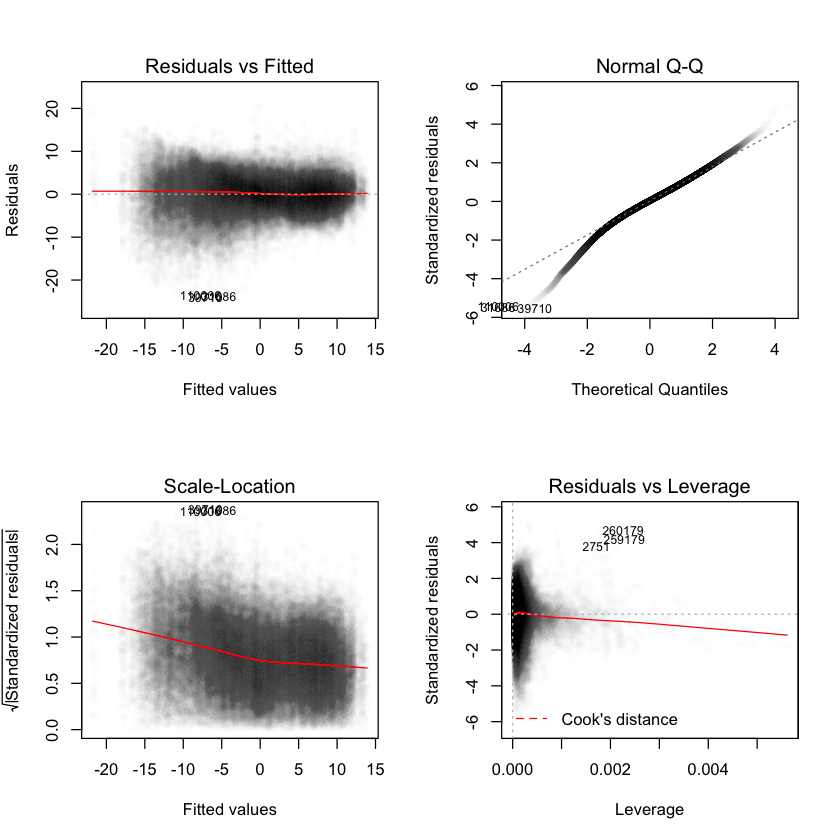

In [17]:
min.temp.mod <- predict.daily(data[-c(36343), ], 'TMIN')
summary(min.temp.mod)
par(mfrow=c(2, 2))
plot(min.temp.mod, pch=16, col=rgb(0, 0, 0, 0.01))

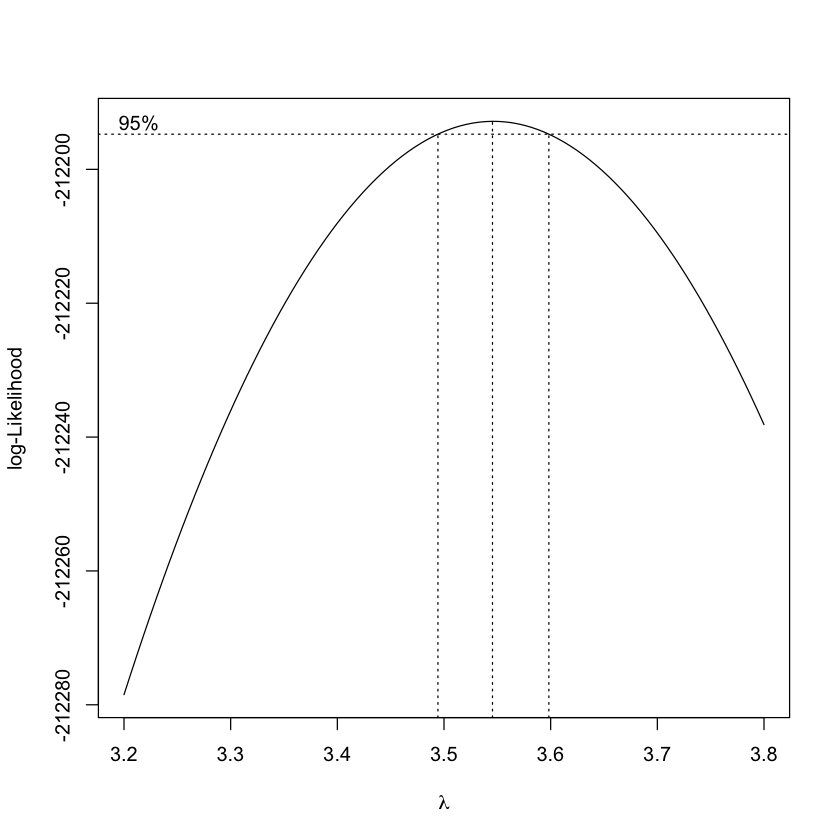

In [18]:
min.temp.mod <- lm(TMIN + 100 ~ monthly.means
                      + YDAY
                      + monthly.precip
                      + monthly.precip:monthly.means 
                      + monthly.precip:YDAY 
                      + monthly.precip:I(YDAY^2) 
                      + I(YDAY^2) 
                      + YDAY:monthly.means 
                      + I(YDAY^2):monthly.means 
                      + sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2)), 
                    data=data[-c(36343), ])
boxcox(min.temp.mod, lambda=seq(3.2, 3.8, length=20))


Call:
lm(formula = tmin ~ monthly.means + YDAY + monthly.precip + monthly.precip:monthly.means + 
    monthly.precip:YDAY + monthly.precip:I(YDAY^2) + I(YDAY^2) + 
    YDAY:monthly.means + I(YDAY^2):monthly.means + sin(pi * (YDAY - 
    DAYS/4 - 30)/(DAYS/2)), data = data[-c(36343), ])

Residuals:
     Min       1Q   Median       3Q      Max 
-2012207  -319751    -4385   313160  3370406 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              3.249e+06  2.014e+04 161.294  < 2e-16
monthly.means                            1.125e+05  1.533e+03  73.351  < 2e-16
YDAY                                    -5.067e+03  2.472e+02 -20.499  < 2e-16
monthly.precip                           3.349e+02  4.386e+01   7.637 2.24e-14
I(YDAY^2)                                1.364e+01  6.063e-01  22.499  < 2e-16
sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2))  1.231e+05  1.092e+04  11.274  < 2e-16
monthly.means:monthly.precip            

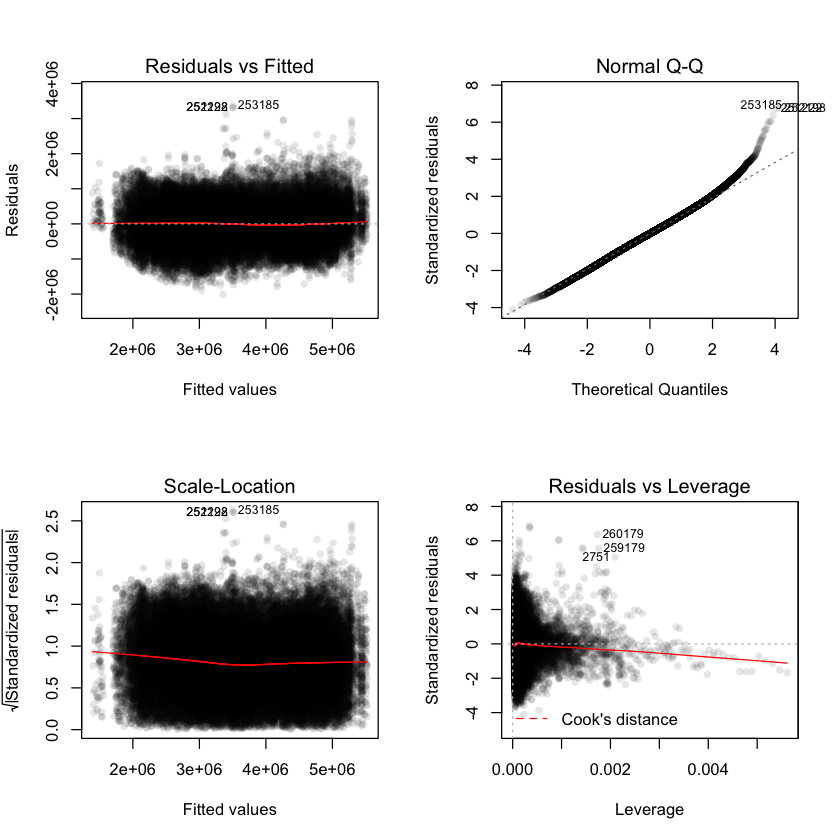

In [30]:
lambda.min <- 3.55
data$tmin <- ((data$TMIN + 100)^lambda.min - 1) / lambda.min
min.temp.mod <- lm(tmin ~ monthly.means
                      + YDAY
                      + monthly.precip
                      + monthly.precip:monthly.means 
                      + monthly.precip:YDAY 
                      + monthly.precip:I(YDAY^2) 
                      + I(YDAY^2) 
                      + YDAY:monthly.means 
                      + I(YDAY^2):monthly.means 
                      + sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2)), 
                    data=data[-c(36343), ])
summary(min.temp.mod)
par(mfrow=c(2, 2))
plot(min.temp.mod, pch=16, col=rgb(0, 0, 0, 0.1))

In [20]:
which(rownames(data) %in% c(4750))

[1] 18058

In [21]:
data[18058, ]

STATION     NAME             LATITUDE LONGITUDE ELEVATION DATE       PRCP
4750 USS0005P04S ELK CABIN, NM US 35.7     -105.81   2502.4    2007-02-16 0   
     TAVG TMAX TMIN YEAR MONTH YDAY monthly.means monthly.precip tavg    
4750 1.4  46.2 -4.7 2007 2     47   -0.45         55.8           280536.5
     tmin   
4750 2989175


Call:
lm(formula = daily[, statistic] ~ monthly.means + YDAY + monthly.precip + 
    I(YDAY^2) + sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2)) + monthly.means:monthly.precip + 
    YDAY:monthly.precip + monthly.means:YDAY + monthly.means:I(YDAY^2), 
    data = daily)

Residuals:
     Min       1Q   Median       3Q      Max 
-22.6340  -2.9252   0.1411   3.0759  31.4050 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              6.888e+00  1.763e-01  39.074  < 2e-16
monthly.means                            7.854e-01  1.314e-02  59.784  < 2e-16
YDAY                                     1.287e-02  1.975e-03   6.518 7.18e-11
monthly.precip                          -6.345e-03  2.577e-04 -24.621  < 2e-16
I(YDAY^2)                               -4.696e-05  4.741e-06  -9.903  < 2e-16
sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2))  2.121e+00  1.015e-01  20.890  < 2e-16
monthly.means:monthly.precip            -1.942e-04  3.202e-05  -6

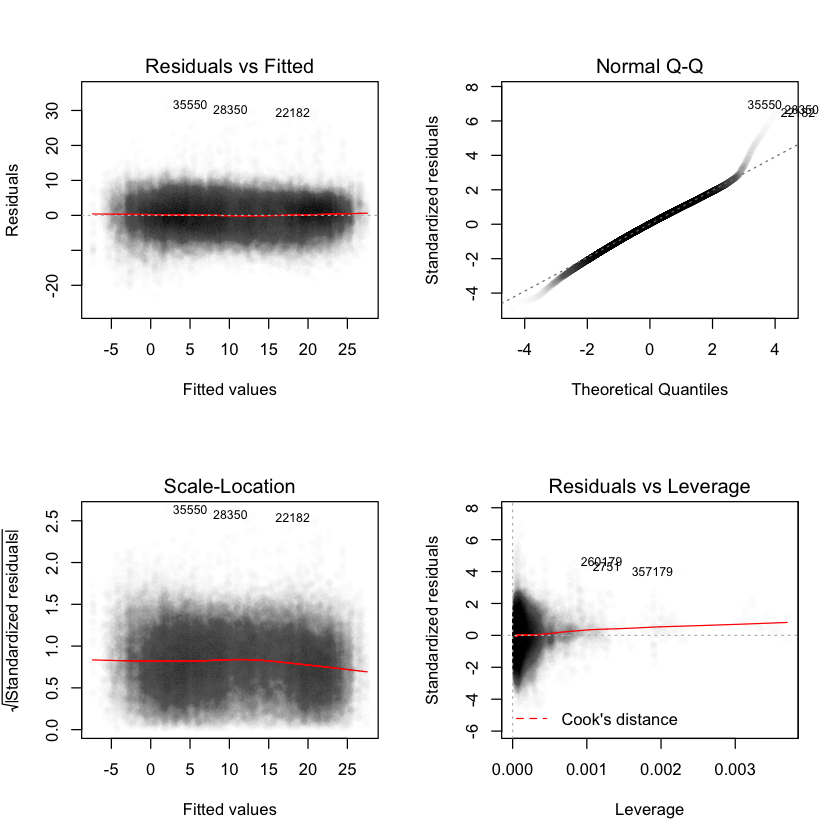

In [22]:
max.temp.mod <- predict.daily(data[-c(18058), ], 'TMAX')
summary(max.temp.mod)
par(mfrow=c(2, 2))
plot(max.temp.mod, pch=16, col=rgb(0, 0, 0, 0.01))

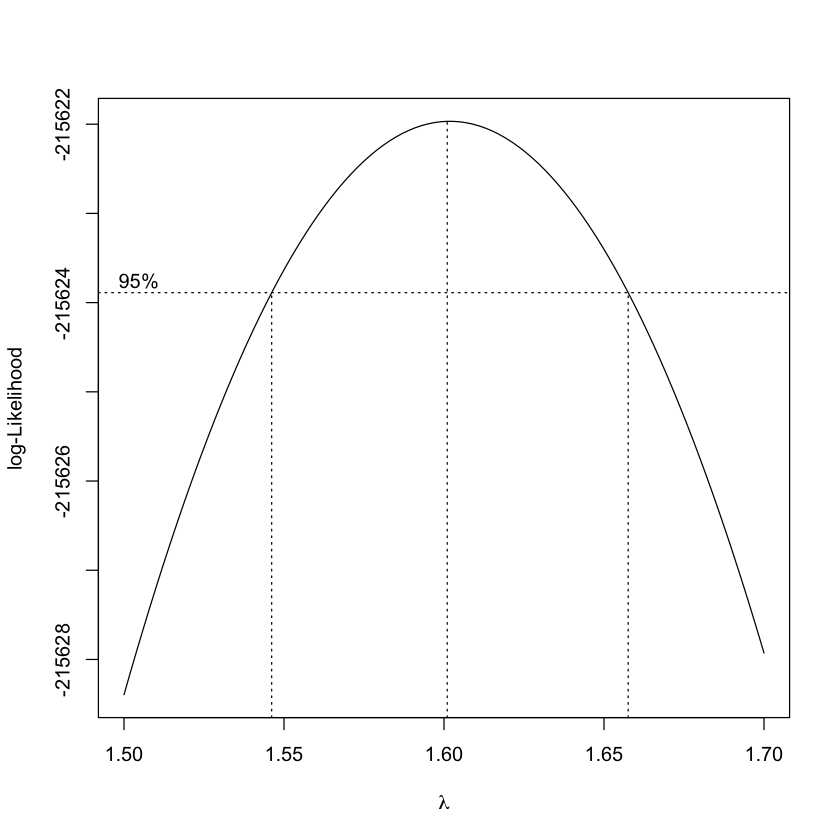

In [46]:
max.temp.mod <- lm(TMAX + 100 ~ monthly.means
                      + YDAY
                      + monthly.precip
                      + monthly.precip:monthly.means 
                      + monthly.precip:YDAY 
                      + I(YDAY^2) 
                      + YDAY:monthly.means 
                      + I(YDAY^2):monthly.means 
                      + sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2)), 
                    data=data[-c(18058), ])
boxcox(max.temp.mod, lambda=seq(1.5, 1.7, length=20))


Call:
lm(formula = tmax ~ monthly.means + YDAY + monthly.precip + monthly.precip:monthly.means + 
    monthly.precip:YDAY + I(YDAY^2) + YDAY:monthly.means + I(YDAY^2):monthly.means + 
    sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2)), data = data[-c(18058), 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-335.56  -49.56    1.48   51.46  554.96 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              1.099e+03  2.954e+00 372.145  < 2e-16
monthly.means                            1.201e+01  2.202e-01  54.537  < 2e-16
YDAY                                     2.257e-01  3.310e-02   6.821 9.09e-12
monthly.precip                          -1.004e-01  4.319e-03 -23.237  < 2e-16
I(YDAY^2)                               -7.897e-04  7.947e-05  -9.937  < 2e-16
sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2))  3.309e+01  1.701e+00  19.453  < 2e-16
monthly.means:monthly.precip            -4.242e-03  5.366e-04  -7.906 2.69e-1

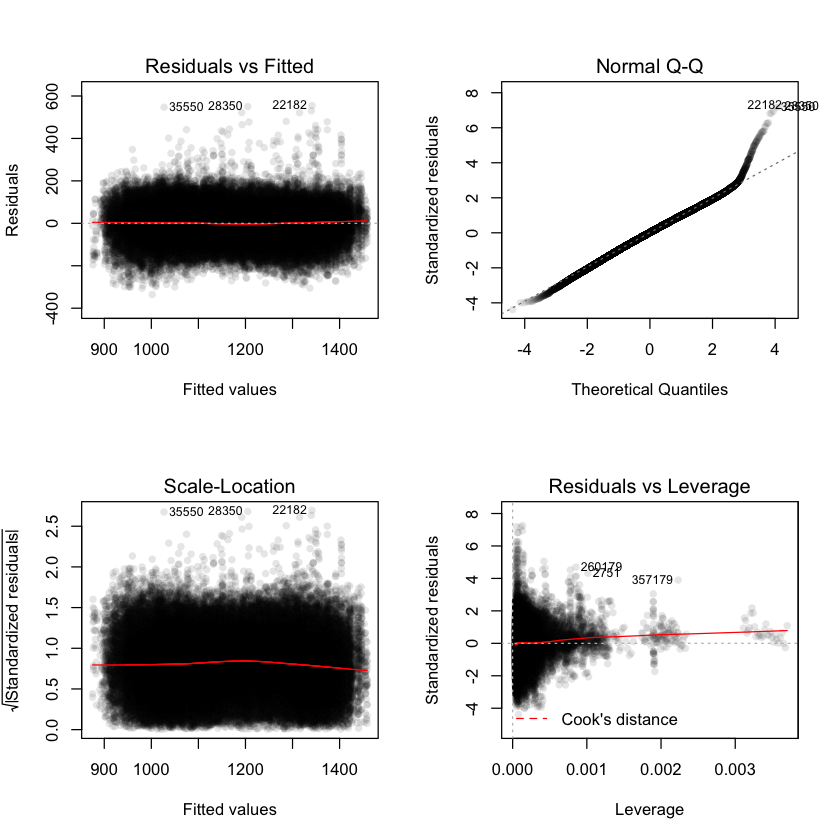

In [53]:
lambda.max <- 1.6
data$tmax <- ((data$TMAX + 100)^lambda.max - 1) / lambda.max
max.temp.mod <- lm(tmax ~ monthly.means
                      + YDAY
                      + monthly.precip
                      + monthly.precip:monthly.means 
                      + monthly.precip:YDAY 
                      + I(YDAY^2) 
                      + YDAY:monthly.means 
                      + I(YDAY^2):monthly.means 
                      + sin(pi * (YDAY - DAYS/4 - 30)/(DAYS/2)), 
                    data=data[-c(18058), ])
summary(max.temp.mod)
par(mfrow=c(2, 2))
plot(max.temp.mod, pch=16, col=rgb(0, 0, 0, 0.1))

In [54]:
prep.data <- function(path) {
  daily <- read.csv(path)
  daily$DATE <- as.Date(daily$DATE, format='%Y-%m-%d')
  daily <- daily[complete.cases(daily), ]
  daily <- daily[order(daily$DATE), ]
  daily$MONTH <- as.numeric(format(daily$DATE, '%m'))
  daily$YDAY <- yday(daily$DATE)
  daily$TAVG[daily$TAVG > 57 | daily$TAVG < -63] <- NA
  daily$TMIN[daily$TMIN > 57 | daily$TMIN < -63] <- NA
  daily$TMAX[daily$TMAX > 57 | daily$TMAX < -63] <- NA
  monthly.means <- tapply(daily$TAVG, daily$MONTH, mean)
  daily$monthly.means <- monthly.means[daily$MONTH]
  monthly.precip <- tapply(daily$PRCP, daily$MONTH, sum)
  daily$monthly.precip <- monthly.precip[daily$MONTH]
  daily$tmin <- ((daily$TMIN + 100)^lambda.min - 1) / lambda.min
  daily$tmax <- ((daily$TMAX + 100)^lambda.max - 1) / lambda.max
  daily$tavg <- ((daily$TAVG + 100)^lambda.avg - 1) / lambda.avg
  daily
}

In [55]:
test <- prep.data(paste(DATA_DIR, files[sample(250, 1)], sep=''))
head(test)

STATION     NAME              LATITUDE LONGITUDE ELEVATION DATE       PRCP
1 USS0021D12S CLEAR LAKE, OR US 45.19    -121.69   1161.3    2007-01-01  7.6
2 USS0021D12S CLEAR LAKE, OR US 45.19    -121.69   1161.3    2007-01-02 17.8
3 USS0021D12S CLEAR LAKE, OR US 45.19    -121.69   1161.3    2007-01-03 43.2
4 USS0021D12S CLEAR LAKE, OR US 45.19    -121.69   1161.3    2007-01-04  7.6
5 USS0021D12S CLEAR LAKE, OR US 45.19    -121.69   1161.3    2007-01-05  7.6
6 USS0021D12S CLEAR LAKE, OR US 45.19    -121.69   1161.3    2007-01-06  5.1
  TAVG TMAX TMIN YEAR MONTH YDAY monthly.means monthly.precip tmin    tmax     
1  2.5  4.6  0.1 2007 1     1    -1.6          119.3          3558874 1063.8383
2  5.0  7.0  3.3 2007 1     2    -1.6          119.3          3979493 1103.1843
3  1.7  4.2 -1.2 2007 1     3    -1.6          119.3          3397495 1057.3329
4 -1.9 -0.3 -3.8 2007 1     4    -1.6          119.3          3090602  985.1828
5 -1.6  0.7 -3.7 2007 1     5    -1.6          119.3          3102022 1001.0508
6 -0.5  1.1 -1.4 2007 1     6    -1.6          119.3          3373142 1007.4245
  tavg    
1 289609.5
2 310946.7
3 282992.1
4 254449.1
5 256751.5
6 265311.2

In [56]:
test.daily.mean <- predict(mean.temp.mod, newdata=test)
test.daily.min <- predict(min.temp.mod, newdata=test)
test.daily.max <- predict(max.temp.mod, newdata=test)

In [57]:
reverse.transform <- function(x, lambda) {
  (lambda * (x + 1))^(1/lambda) - 100
}

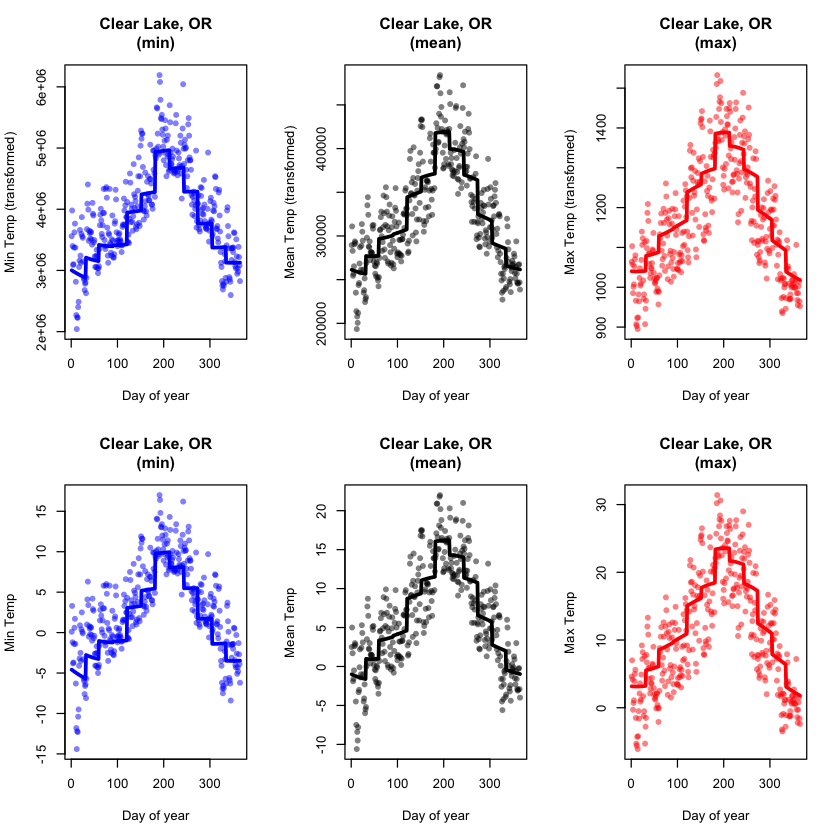

In [58]:
loc <- 'Clear Lake, OR'
par(mfrow=c(2, 3))
plot(test$tmin ~ test$YDAY, 
     pch=16, 
     col=rgb(0, 0, 1, 0.5), 
     main=paste(loc, '(min)', sep='\n'),
     xlab='Day of year',
     ylab='Min Temp (transformed)')
lines(test.daily.min ~ test$YDAY, col=4, lwd=3)
plot(test$tavg ~ test$YDAY, 
     pch=16, 
     col=rgb(0, 0, 0, 0.5), 
     main=paste(loc, '(mean)', sep='\n'),
     xlab='Day of year',
     ylab='Mean Temp (transformed)')
lines(test.daily.mean ~ test$YDAY, col=1, lwd=3)
plot(test$tmax ~ test$YDAY, 
     pch=16, 
     col=rgb(1, 0, 0, 0.5), 
     main=paste(loc, '(max)', sep='\n'),
     xlab='Day of year',
     ylab='Max Temp (transformed)')
lines(test.daily.max ~ test$YDAY, col=2, lwd=3)

plot(test$TMIN ~ test$YDAY, 
     pch=16, 
     col=rgb(0, 0, 1, 0.5), 
     main=paste(loc, '(min)', sep='\n'),
     xlab='Day of year',
     ylab='Min Temp')
lines(reverse.transform(test.daily.min, lambda.min) ~ test$YDAY, col=4, lwd=3)
plot(test$TAVG ~ test$YDAY, 
     pch=16, 
     col=rgb(0, 0, 0, 0.5), 
     main=paste(loc, '(mean)', sep='\n'),
     xlab='Day of year',
     ylab='Mean Temp')
lines(reverse.transform(test.daily.mean, lambda.avg) ~ test$YDAY, col=1, lwd=3)
plot(test$TMAX ~ test$YDAY, 
     pch=16, 
     col=rgb(1, 0, 0, 0.5), 
     main=paste(loc, '(max)', sep='\n'),
     xlab='Day of year',
     ylab='Max Temp')
lines(reverse.transform(test.daily.max, lambda.max) ~ test$YDAY, col=2, lwd=3)

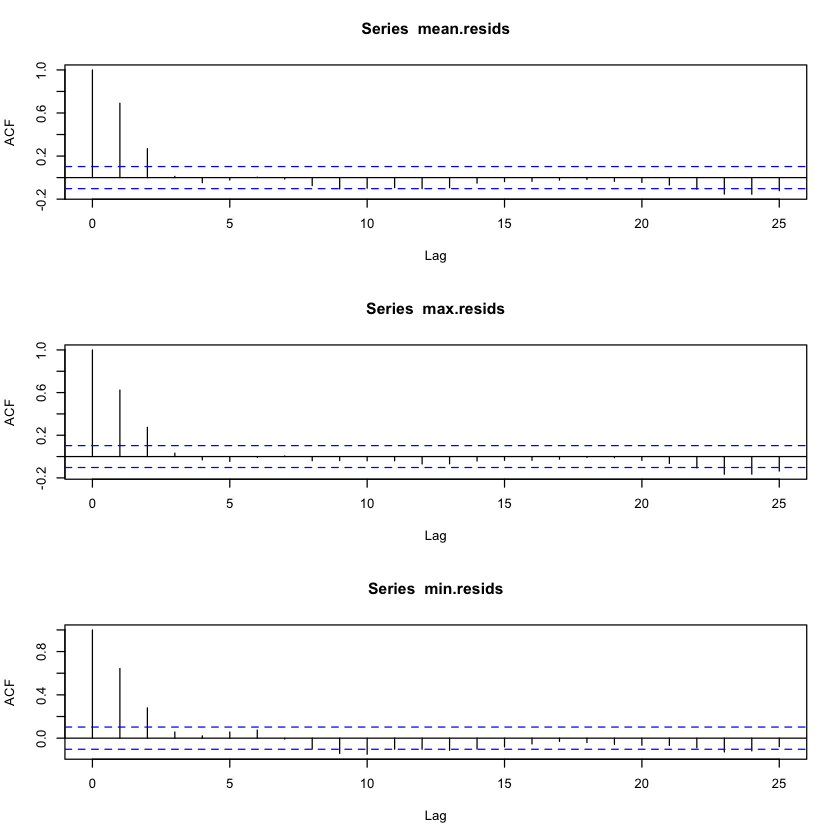

In [59]:
mean.resids <- test.daily.mean - test$tavg
max.resids <- test.daily.max - test$tmax
min.resids <- test.daily.min - test$tmin

par(mfrow=c(3, 1))
acf(mean.resids)
acf(max.resids)
acf(min.resids)

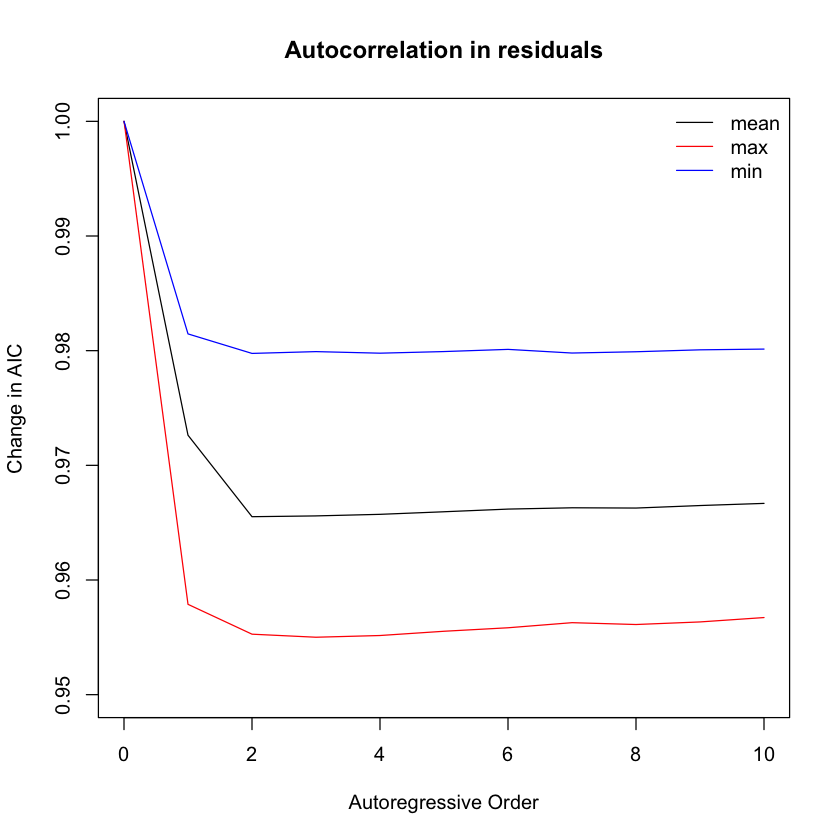

In [60]:
mean.aics.ar <- numeric(11)
max.aics.ar <- numeric(11)
min.aics.ar <- numeric(11)

for (ar in 0:10) {
  mean.ar.mod <- arima(mean.resids, order=c(ar, 0, 0))
  mean.aics.ar[ar + 1] <- mean.ar.mod$aic

  max.ar.mod <- arima(max.resids, order=c(ar, 0, 0))
  max.aics.ar[ar + 1] <- max.ar.mod$aic

  min.ar.mod <- arima(min.resids, order=c(ar, 0, 0))
  min.aics.ar[ar + 1] <- min.ar.mod$aic
}

ar <- 0:10
plot(mean.aics.ar / mean.aics.ar[1] ~ ar, 
     type='l', 
     ylim=c(0.95, 1), 
     main='Autocorrelation in residuals',
     xlab='Autoregressive Order',
     ylab='Change in AIC')
lines(max.aics.ar / max.aics.ar[1] ~ ar, col=2)
lines(min.aics.ar / min.aics.ar[1] ~ ar, col=4)
legend('topright', 
       lty=1, 
       col=c(1, 2, 4), 
       legend=c('mean', 'max', 'min'), 
       bty='n')

In [68]:
test <- prep.data(paste(DATA_DIR, files[sample(250, 1)], sep=''))
head(test)

STATION     NAME                  LATITUDE LONGITUDE ELEVATION DATE      
1 USS0010C08S S FORK SHIELDS, MT US 46.09    -110.43   2468.9    2009-01-01
2 USS0010C08S S FORK SHIELDS, MT US 46.09    -110.43   2468.9    2009-01-02
3 USS0010C08S S FORK SHIELDS, MT US 46.09    -110.43   2468.9    2009-01-03
4 USS0010C08S S FORK SHIELDS, MT US 46.09    -110.43   2468.9    2009-01-04
5 USS0010C08S S FORK SHIELDS, MT US 46.09    -110.43   2468.9    2009-01-05
6 USS0010C08S S FORK SHIELDS, MT US 46.09    -110.43   2468.9    2009-01-06
  PRCP TAVG  TMAX  TMIN  YEAR MONTH YDAY monthly.means monthly.precip tmin   
1 12.7  -6.4  -1.5 -11.0 2009 1     1    -5.306452     50.6           2344802
2  0.0  -4.4   1.3 -13.6 2009 1     2    -5.306452     50.6           2110549
3  0.0 -17.2 -13.5 -20.2 2009 1     3    -5.306452     50.6           1591776
4  2.5 -13.4  -6.6 -17.6 2009 1     4    -5.306452     50.6           1783665
5  2.5  -7.8  -6.8  -9.6 2009 1     5    -5.306452     50.6           2478389
6 12.7  -5.9  -1.5  -7.6 2009 1     6    -5.306452     50.6           2678595
  tmax      tavg    
1  966.2670 221534.3
2 1010.6171 235791.5
3  784.8019 154300.2
4  887.4201 176138.8
5  884.3795 211901.2
6  966.2670 225043.6

In [69]:
test.daily.mean <- predict(mean.temp.mod, newdata=test)
test.daily.min <- predict(min.temp.mod, newdata=test)
test.daily.max <- predict(max.temp.mod, newdata=test)

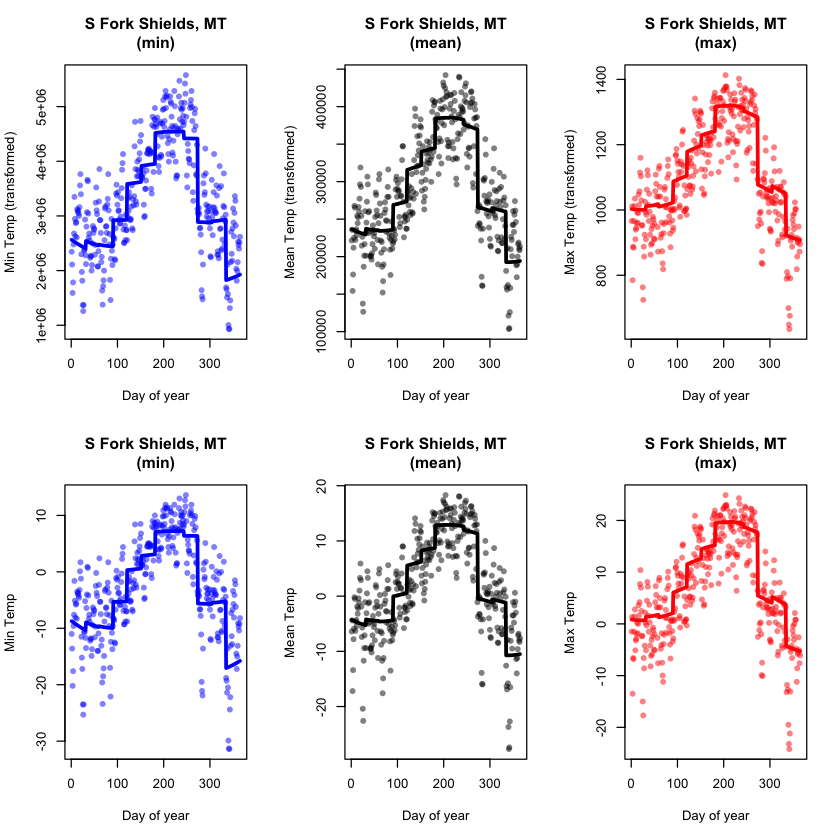

In [70]:
loc <- 'S Fork Shields, MT'
par(mfrow=c(2, 3))
plot(test$tmin ~ test$YDAY, 
     pch=16, 
     col=rgb(0, 0, 1, 0.5), 
     main=paste(loc, '(min)', sep='\n'),
     xlab='Day of year',
     ylab='Min Temp (transformed)')
lines(test.daily.min ~ test$YDAY, col=4, lwd=3)
plot(test$tavg ~ test$YDAY, 
     pch=16, 
     col=rgb(0, 0, 0, 0.5), 
     main=paste(loc, '(mean)', sep='\n'),
     xlab='Day of year',
     ylab='Mean Temp (transformed)')
lines(test.daily.mean ~ test$YDAY, col=1, lwd=3)
plot(test$tmax ~ test$YDAY, 
     pch=16, 
     col=rgb(1, 0, 0, 0.5), 
     main=paste(loc, '(max)', sep='\n'),
     xlab='Day of year',
     ylab='Max Temp (transformed)')
lines(test.daily.max ~ test$YDAY, col=2, lwd=3)

plot(test$TMIN ~ test$YDAY, 
     pch=16, 
     col=rgb(0, 0, 1, 0.5), 
     main=paste(loc, '(min)', sep='\n'),
     xlab='Day of year',
     ylab='Min Temp')
lines(reverse.transform(test.daily.min, lambda.min) ~ test$YDAY, col=4, lwd=3)
plot(test$TAVG ~ test$YDAY, 
     pch=16, 
     col=rgb(0, 0, 0, 0.5), 
     main=paste(loc, '(mean)', sep='\n'),
     xlab='Day of year',
     ylab='Mean Temp')
lines(reverse.transform(test.daily.mean, lambda.avg) ~ test$YDAY, col=1, lwd=3)
plot(test$TMAX ~ test$YDAY, 
     pch=16, 
     col=rgb(1, 0, 0, 0.5), 
     main=paste(loc, '(max)', sep='\n'),
     xlab='Day of year',
     ylab='Max Temp')
lines(reverse.transform(test.daily.max, lambda.max) ~ test$YDAY, col=2, lwd=3)

In [75]:
test <- prep.data(paste(DATA_DIR, files[sample(250, 1)], sep=''))
head(test)

STATION     NAME             LATITUDE LONGITUDE ELEVATION DATE       PRCP
1 USS0049L09S GRANDVIEW, AK US 60.61    -149.06   335.3     2011-01-01  2.5
2 USS0049L09S GRANDVIEW, AK US 60.61    -149.06   335.3     2011-01-02  0.0
3 USS0049L09S GRANDVIEW, AK US 60.61    -149.06   335.3     2011-01-03 20.3
4 USS0049L09S GRANDVIEW, AK US 60.61    -149.06   335.3     2011-01-04 12.7
5 USS0049L09S GRANDVIEW, AK US 60.61    -149.06   335.3     2011-01-05  7.6
6 USS0049L09S GRANDVIEW, AK US 60.61    -149.06   335.3     2011-01-06  2.5
  TAVG TMAX TMIN YEAR MONTH YDAY monthly.means monthly.precip tmin    tmax     
1  1.4  3.2 -1.1 2011 1     1    -6.416129     144.6          3409718 1041.1347
2  3.0  4.7  1.9 2011 1     2    -6.416129     144.6          3791316 1065.4671
3  1.3  2.6  0.7 2011 1     3    -6.416129     144.6          3635183 1031.4608
4  0.9  2.3 -0.3 2011 1     4    -6.416129     144.6          3508645 1026.6365
5 -1.6  0.3 -6.1 2011 1     5    -6.416129     144.6          2836184  994.6922
6 -7.1 -5.9 -9.7 2011 1     6    -6.416129     144.6          2468670  898.0929
  tavg    
1 280536.5
2 293797.0
3 279721.2
4 276475.3
5 256751.5
6 216682.4

In [76]:
test.daily.mean <- predict(mean.temp.mod, newdata=test)
test.daily.min <- predict(min.temp.mod, newdata=test)
test.daily.max <- predict(max.temp.mod, newdata=test)

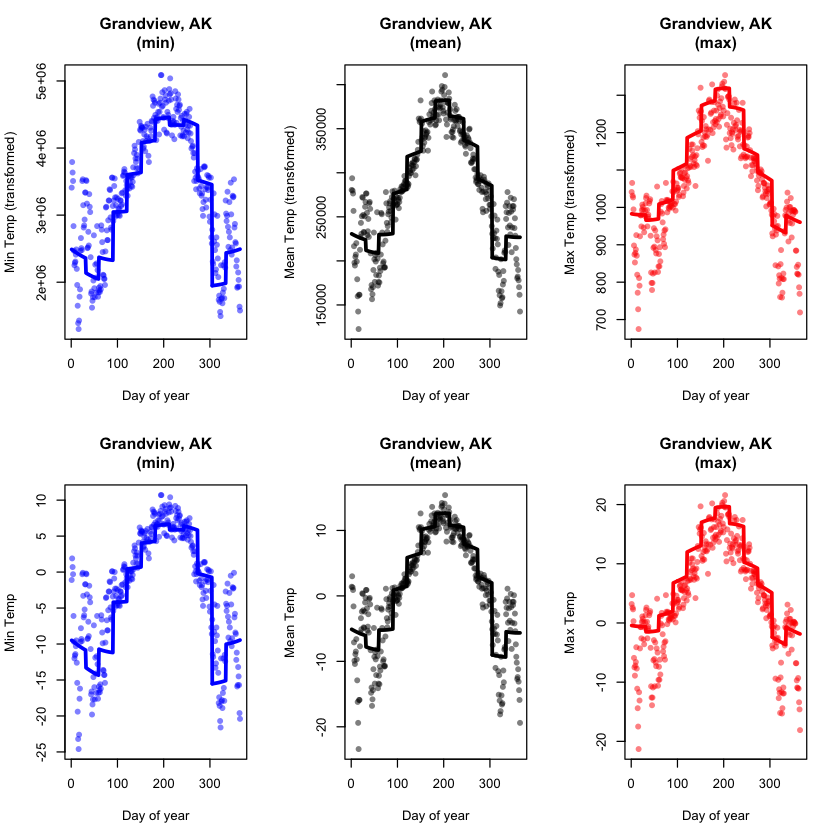

In [77]:
loc <- 'Grandview, AK'
par(mfrow=c(2, 3))
plot(test$tmin ~ test$YDAY, 
     pch=16, 
     col=rgb(0, 0, 1, 0.5), 
     main=paste(loc, '(min)', sep='\n'),
     xlab='Day of year',
     ylab='Min Temp (transformed)')
lines(test.daily.min ~ test$YDAY, col=4, lwd=3)
plot(test$tavg ~ test$YDAY, 
     pch=16, 
     col=rgb(0, 0, 0, 0.5), 
     main=paste(loc, '(mean)', sep='\n'),
     xlab='Day of year',
     ylab='Mean Temp (transformed)')
lines(test.daily.mean ~ test$YDAY, col=1, lwd=3)
plot(test$tmax ~ test$YDAY, 
     pch=16, 
     col=rgb(1, 0, 0, 0.5), 
     main=paste(loc, '(max)', sep='\n'),
     xlab='Day of year',
     ylab='Max Temp (transformed)')
lines(test.daily.max ~ test$YDAY, col=2, lwd=3)

plot(test$TMIN ~ test$YDAY, 
     pch=16, 
     col=rgb(0, 0, 1, 0.5), 
     main=paste(loc, '(min)', sep='\n'),
     xlab='Day of year',
     ylab='Min Temp')
lines(reverse.transform(test.daily.min, lambda.min) ~ test$YDAY, col=4, lwd=3)
plot(test$TAVG ~ test$YDAY, 
     pch=16, 
     col=rgb(0, 0, 0, 0.5), 
     main=paste(loc, '(mean)', sep='\n'),
     xlab='Day of year',
     ylab='Mean Temp')
lines(reverse.transform(test.daily.mean, lambda.avg) ~ test$YDAY, col=1, lwd=3)
plot(test$TMAX ~ test$YDAY, 
     pch=16, 
     col=rgb(1, 0, 0, 0.5), 
     main=paste(loc, '(max)', sep='\n'),
     xlab='Day of year',
     ylab='Max Temp')
lines(reverse.transform(test.daily.max, lambda.max) ~ test$YDAY, col=2, lwd=3)

In [79]:
n <- length(files)
mean.orders <- numeric(n)
max.orders <- numeric(n)
min.orders <- numeric(n)

for (i in 1:n) {
  data <- prep.data(paste(DATA_DIR, files[i], sep=''))
  test.daily.mean <- predict(mean.temp.mod, newdata=data)
  test.daily.min <- predict(min.temp.mod, newdata=data)
  test.daily.max <- predict(max.temp.mod, newdata=data)
  mean.resid <- test.daily.mean - data$tavg
  max.resid <- test.daily.max - data$tmax
  min.resid <- test.daily.min - data$tmin

  best.mean.order <- 0
  best.max.order <- 0
  best.min.order <- 0
  best.mean.aic <- Inf
  best.max.aic <- Inf
  best.min.aic <- Inf

  for (ar in 0:8) {
    mean.ar.mod <- arima(mean.resid, order=c(ar, 0, 0))
    if (mean.ar.mod$aic < best.mean.aic) {
      best.mean.order <- ar
      best.mean.aic <- mean.ar.mod$aic
    }
      
    max.ar.mod <- arima(max.resid, order=c(ar, 0, 0))
    if (max.ar.mod$aic < best.max.aic) {
      best.max.order <- ar
      best.max.aic <- max.ar.mod$aic
    }

    min.ar.mod <- arima(min.resid, order=c(ar, 0, 0))
    if (min.ar.mod$aic < best.min.aic) {
      best.min.order <- ar
      best.min.aic <- mean.ar.mod$aic
    }
  }
    
  mean.orders[i] <- best.mean.order
  max.orders[i] <- best.max.order
  min.orders[i] <- best.min.order
}

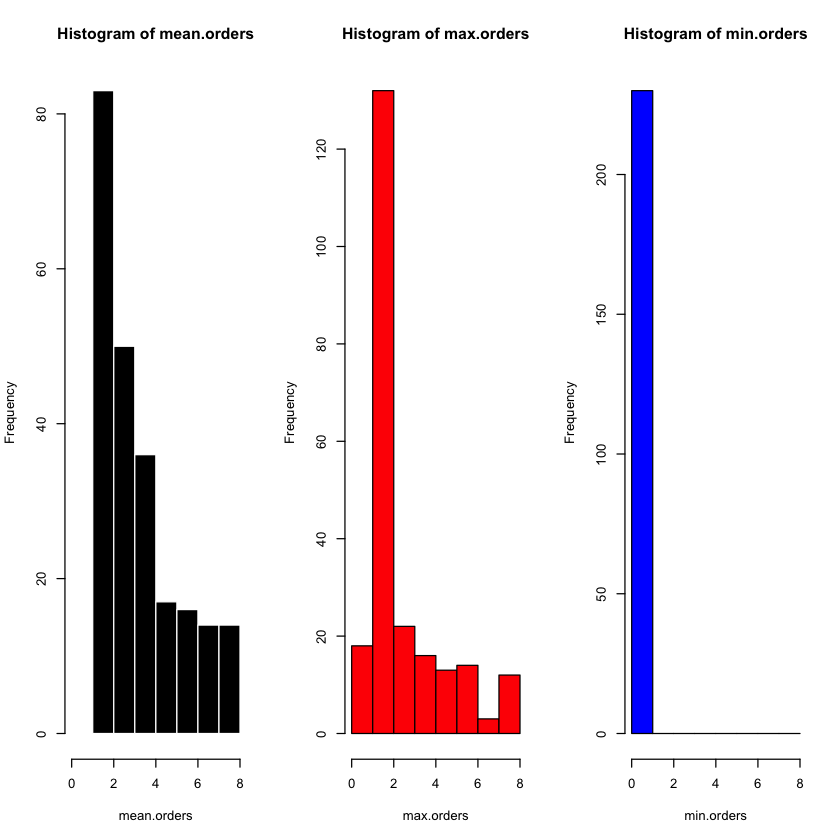

In [80]:
par(mfrow=c(1, 3))
hist(mean.orders, col=1, border='white', xlim=c(0, 8), breaks=0:8)
hist(max.orders, col=2, xlim=c(0, 8), breaks=0:8)
hist(min.orders, col=4, xlim=c(0, 8), breaks=0:8)

In [132]:
table(mean.orders)
table(max.orders)
table(min.orders)
# 2nd order for mean and max, 1st order for min

mean.orders
 2  3  4  5  6  7  8 
74 44 33 18 21 15 25 

max.orders
  1   2   3   4   5   6   7   8 
 17 129  22  18  14  14   3  13 

min.orders
  0   1   2   3   4   5   6   8 
 14 146  24   3   3   1   1  38 

In [81]:
data <- prep.data(paste(DATA_DIR, files[sample(250, 1)], sep=''))
test.daily.mean <- predict(mean.temp.mod, newdata=data)
test.daily.min <- predict(min.temp.mod, newdata=data)
test.daily.max <- predict(max.temp.mod, newdata=data)
mean.resid <- test.daily.mean - data$tavg
max.resid <- test.daily.max - data$tmax
min.resid <- test.daily.min - data$tmin

In [82]:
arima.mean <- arima(mean.resid, order=c(2, 0, 0))
arima.max <- arima(max.resid, order=c(2, 0, 0))
arima.min <- arima(min.resid, order=c(1, 0, 0))

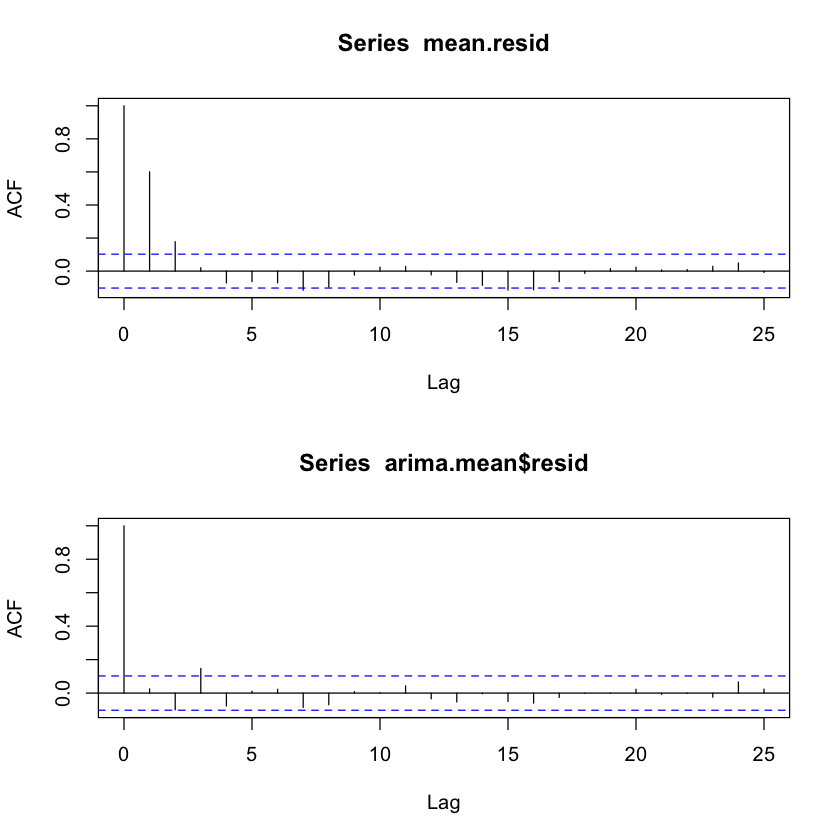

In [83]:
par(mfrow=c(2, 1))
acf(mean.resid)
acf(arima.mean$resid)

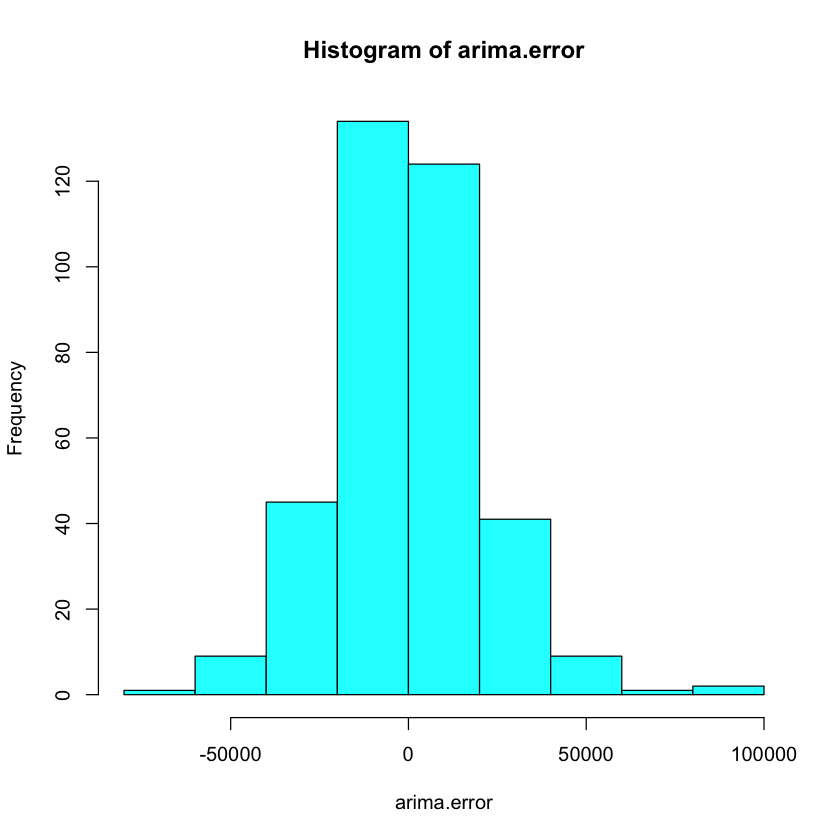

In [85]:
arima.error <- arima.mean$resid
hist(arima.error, col=5)

In [86]:
mean(arima.error)
sd(arima.error)

[1] -49.36766

[1] 20989.49

In [87]:
(ar.coef <- arima.mean$coef)

ar1          ar2    intercept 
   0.7842136   -0.2946365 3057.7308172

In [88]:
n <- length(arima.error)
last2 <- arima.error[(n-1):n]

In [97]:
pseudo.arima.error <- rnorm(n + 2, mean(arima.error), sd(arima.error))
pseudo.resids <- numeric(n + 2)

# use end of year to seed beginning
pseudo.resids[1:2] <- arima.error[(n-1):n]
for (t in 3:(n + 2)) {
  pseudo.resids[t] <- (ar.coef['intercept']
                       + ar.coef['ar1']*pseudo.resids[t - 1]
                       + ar.coef['ar2'] *pseudo.resids[t - 2]
                       + pseudo.arima.error[t])
}

pseudo.resids <- pseudo.resids[-c(1:2)]
length(test.daily.mean)
length(pseudo.resids)

[1] 366

[1] 366

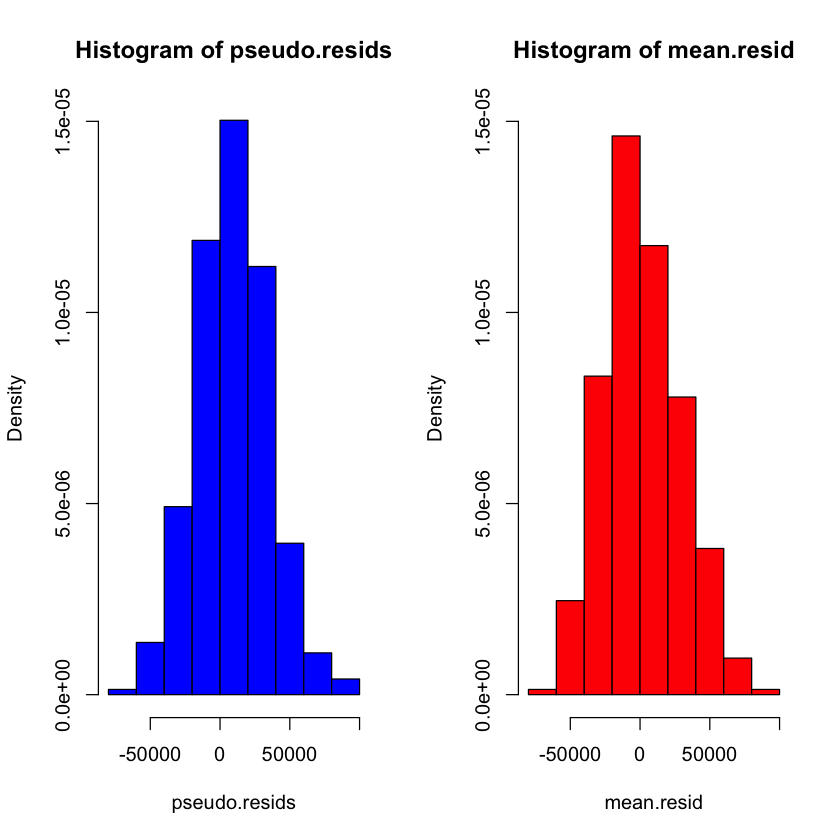

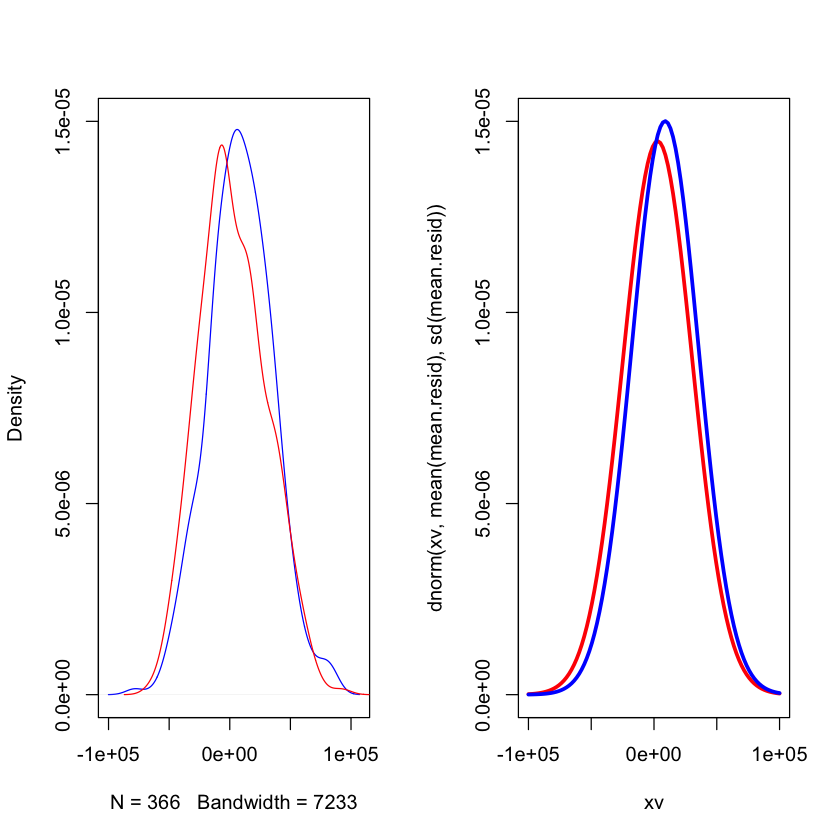

In [101]:
par(mfrow=c(1, 2))
xv <- seq(-100000, 100000, length=100)
hist(pseudo.resids, col=4, freq=F, ylim=c(0, 0.000015))
hist(mean.resid, col=2, freq=F, ylim=c(0, 0.000015))
plot(density(pseudo.resids), col=4, ylim=c(0, 0.000015), main='')
lines(density(mean.resid), col=2)

plot(xv,
     dnorm(xv, mean(mean.resid), sd(mean.resid)),
     col=2,
     type='l',
     lwd=3,
     ylim=c(0, 0.000015))
lines(xv, dnorm(xv, mean(pseudo.resids), sd(pseudo.resids)), col=4, lwd=3)

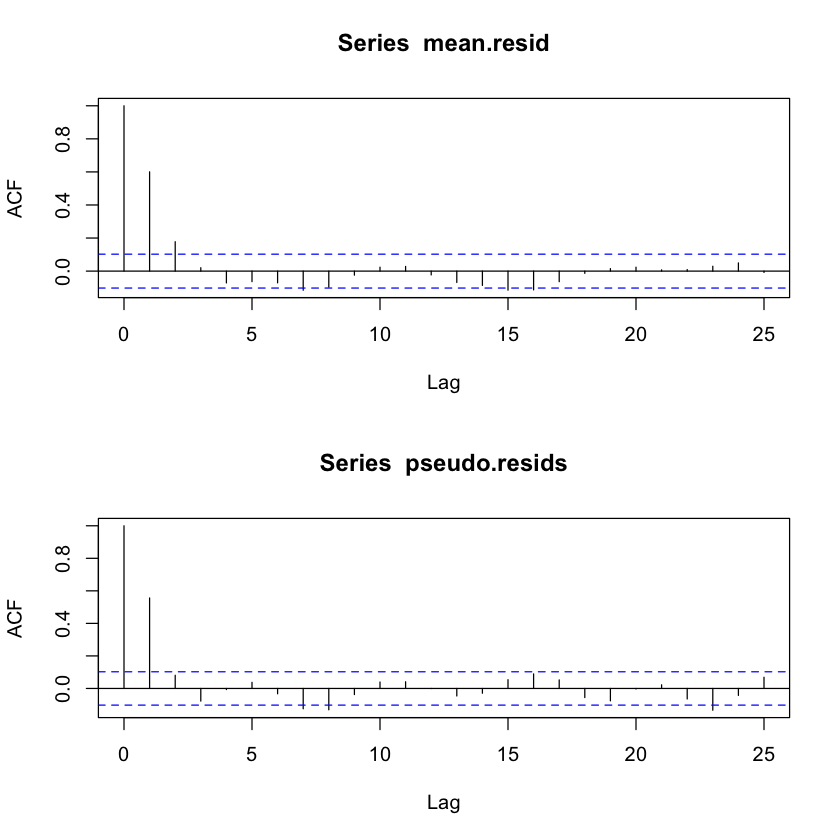

In [103]:
par(mfrow=c(2, 1))
acf(mean.resid)
acf(pseudo.resids)

In [104]:
pseudo.data <- test.daily.mean + pseudo.resids

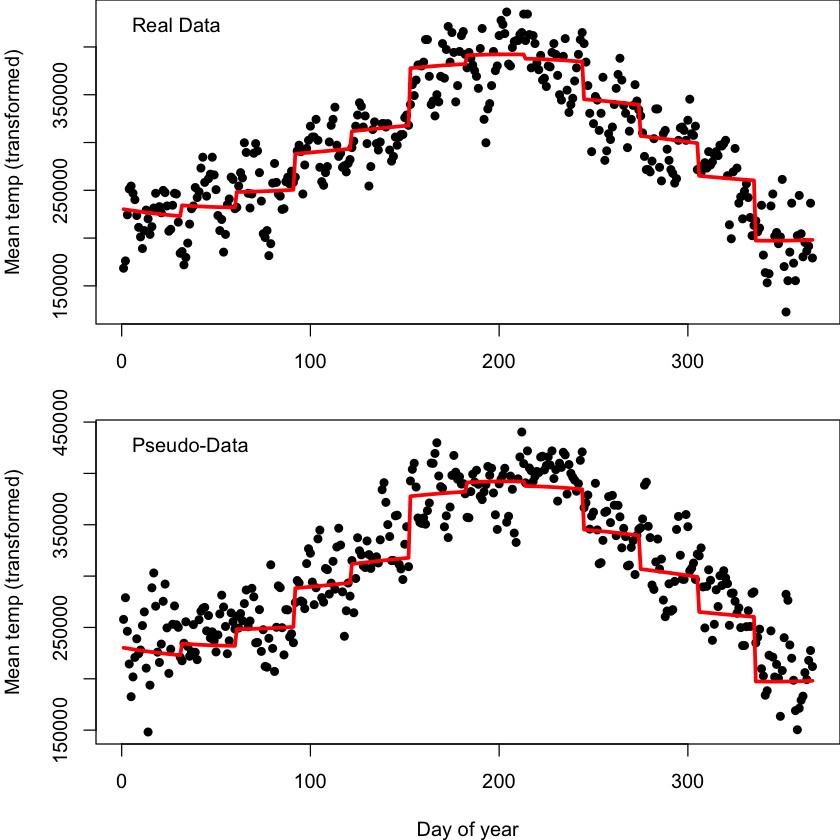

In [109]:
par(mfrow=c(2, 1))
par(mar=c(4, 4, 0, 0))
plot(data$tavg,
     pch=16,
     ylab='Mean temp (transformed)',
     xlab='')
lines(test.daily.mean, col=2, lwd=3)
legend('topleft', 'Real Data', bty='n')
plot(pseudo.data, 
     xlab='Day of year', 
     ylab='Mean temp (transformed)', 
     pch=16)
lines(test.daily.mean, col=2, lwd=3)
legend('topleft', 'Pseudo-Data', bty='n')

In [328]:
compile.arima.coefs <- function() {
  DAT_DIR <- '../data/clean/'
  out <- data.frame(mean.int=c(), mean.ar1=c(), mean.ar2=c(),
                    min.int=c(), min.ar1=c(),
                    max.int=c(), max.ar1=c(), max.ar2=c(),
                    mean.mean.resid=c(), sd.mean.resid=c(),
                    mean.min.resid=c(), sd.min.resid=c(),
                    mean.max.resid=c(), sd.max.resid=c(),
                    LATITUDE=c(), LONGITUDE=c(), ELEVATION=c(), 
                    ANNUAL_PRECIP=c(), location=c(),
                    MEAN_TEMP=c(), MIN_MEANTEMP=c(), MAX_MEANTEMP=c(),
                    MEAN_PRECIP=c(), MIN_PRECIP=c(), MAX_PRECIP=c())
  for (file in files) {
    path <- paste(DATA_DIR, file, sep='')
    daily <- prep.data(path)
    mean.fitted <- predict(mean.temp.mod, newdata=daily)
    min.fitted <- predict(min.temp.mod, newdata=daily)
    max.fitted <- predict(max.temp.mod, newdata=daily)
    mean.resid <- mean.fitted - daily$tavg
    min.resid <- min.fitted - daily$tmin
    max.resid <- max.fitted - daily$tmax
    mean.mean.resid <- mean(mean.resid, na.rm=T)
    sd.mean.resid <- sd(mean.resid, na.rm=T)
    mean.min.resid <- mean(min.resid, na.rm=T)
    sd.min.resid <- sd(min.resid, na.rm=T)
    mean.max.resid <- mean(max.resid, na.rm=T)
    sd.max.resid <- sd(max.resid, na.rm=T)
    mean.ar <- arima(mean.resid, order=c(2, 0, 0))
    min.ar <- arima(min.resid, order=c(1, 0, 0))
    max.ar <- arima(max.resid, order=c(2, 0, 0))
    mean.int <- mean.ar$coef['intercept']
    mean.ar1 <- mean.ar$coef['ar1']
    mean.ar2 <- mean.ar$coef['ar2']
    min.int <- min.ar$coef['intercept']
    min.ar1 <- min.ar$coef['ar1']
    max.int <- max.ar$coef['intercept']
    max.ar1 <- max.ar$coef['ar1']
    max.ar2 <- max.ar$coef['ar2']
    row <- data.frame(
        mean.int=mean.int, mean.ar1=mean.ar1, mean.ar2=mean.ar2,
        min.int=min.int, min.ar1=min.ar1,
        max.int=max.int, max.ar1=max.ar1, max.ar2=max.ar2,
        mean.mean.resid=mean.mean.resid, sd.mean.resid=sd.mean.resid,
        mean.min.resid=mean.min.resid, sd.min.resid=sd.min.resid,
        mean.max.resid=mean.max.resid, sd.max.resid=sd.max.resid,
        LATITUDE=daily[1, 'LATITUDE'], LONGITUDE=daily[1, 'LONGITUDE'],
        ELEVATION=daily[1, 'ELEVATION'], 
        MEAN_PRECIP=mean(daily$monthly.precip, na.rm=T),
        MIN_PRECIP=min(daily$monthly.precip, na.rm=T),
        MAX_PRECIP=max(daily$monthly.precip, na.rm=T),
        location=paste(daily[1, 'NAME'], daily[1, 'YEAR']),
        MEAN_TEMP=mean(daily$monthly.means, na.rm=T), 
        MIN_MEANTEMP=min(daily$monthly.means, na.rm=T),
        MAX_MEANTEMP=max(daily$monthly.means, na.rm=T))
    out <- rbind(out, row)
  }
  rownames(out) <- out$location
  out[, -which(names(out) == 'location')]
}

In [329]:
arima.coefs <- compile.arima.coefs()

In [330]:
head(arima.coefs)

mean.int   mean.ar1  mean.ar2   min.int    min.ar1  
ALPINE MEADOWS, WA US 2007   2302.690 0.8533270 -0.3040179  -48249.47 0.7172934
ALPINE MEADOWS, WA US 2008 -21239.763 1.0170485 -0.2084671 -281395.85 0.8326977
ALPINE MEADOWS, WA US 2009   1074.838 0.9114756 -0.2799529  -79315.22 0.7581557
ALPINE MEADOWS, WA US 2010   1379.989 0.9478383 -0.3386621 -101393.26 0.7298759
ALPINE MEADOWS, WA US 2011   4040.826 0.8234303 -0.2483694  -40489.23 0.7474214
ALPINE MEADOWS, WA US 2012   2465.259 0.8747581 -0.3020496  -42783.02 0.7353867
                           max.int     max.ar1   max.ar2     mean.mean.resid
ALPINE MEADOWS, WA US 2007  -0.1967326 0.6588375 -0.10098550   2282.565     
ALPINE MEADOWS, WA US 2008 -61.4853098 0.8126433 -0.03820918 -21127.081     
ALPINE MEADOWS, WA US 2009   7.7580222 0.7528287 -0.14166334   1172.354     
ALPINE MEADOWS, WA US 2010  13.1256046 0.7386939 -0.15587236   1340.486     
ALPINE MEADOWS, WA US 2011  13.6747208 0.6625615 -0.14657415   3883.239     
ALPINE MEADOWS, WA US 2012   6.5129777 0.7102144 -0.15145140   2445.444     
                           sd.mean.resid ⋯ sd.max.resid LATITUDE LONGITUDE
ALPINE MEADOWS, WA US 2007 27893.82      ⋯ 80.77029     47.78    -121.7   
ALPINE MEADOWS, WA US 2008 41316.30      ⋯ 97.27653     47.78    -121.7   
ALPINE MEADOWS, WA US 2009 31623.43      ⋯ 82.56269     47.78    -121.7   
ALPINE MEADOWS, WA US 2010 28560.51      ⋯ 73.22907     47.78    -121.7   
ALPINE MEADOWS, WA US 2011 23311.93      ⋯ 63.50730     47.78    -121.7   
ALPINE MEADOWS, WA US 2012 27239.30      ⋯ 69.76063     47.78    -121.7   
                           ELEVATION MEAN_PRECIP MIN_PRECIP MAX_PRECIP
ALPINE MEADOWS, WA US 2007 1066.8    346.2162    45.7       759.3     
ALPINE MEADOWS, WA US 2008 1066.8    534.0115     0.0       855.8     
ALPINE MEADOWS, WA US 2009 1066.8    339.3585    12.7       817.8     
ALPINE MEADOWS, WA US 2010 1066.8    347.0115    25.4       645.1     
ALPINE MEADOWS, WA US 2011 1066.8    385.6395    71.2       772.1     
ALPINE MEADOWS, WA US 2012 1066.8    401.2213    10.1       767.2     
                           MEAN_TEMP MIN_MEANTEMP MAX_MEANTEMP
ALPINE MEADOWS, WA US 2007 5.650685  -0.4419355   14.33226    
ALPINE MEADOWS, WA US 2008 2.032810  -1.5000000   11.86667    
ALPINE MEADOWS, WA US 2009 5.793407  -0.6516129   15.30645    
ALPINE MEADOWS, WA US 2010 5.821644   0.2838710   13.21935    
ALPINE MEADOWS, WA US 2011 4.816986  -1.2321429   13.08333    
ALPINE MEADOWS, WA US 2012 5.715847  -0.3161290   14.59677

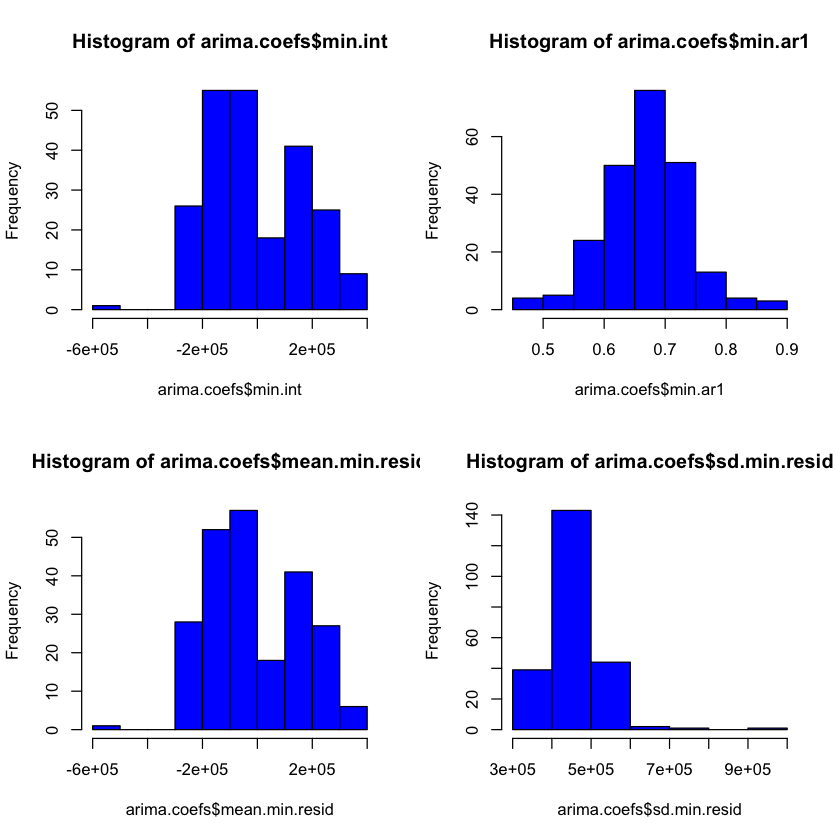

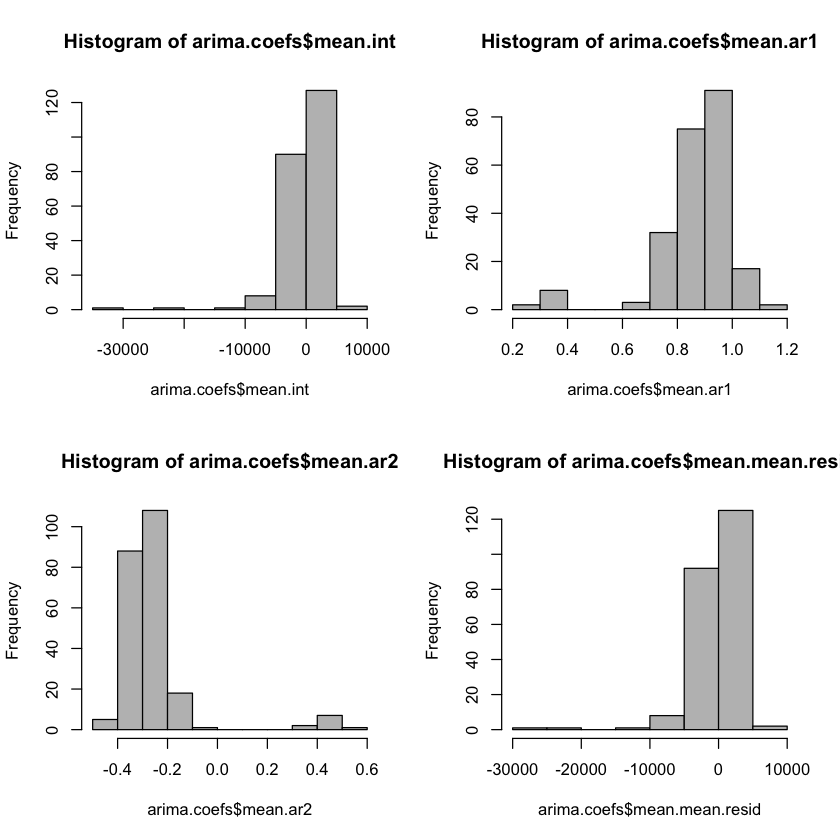

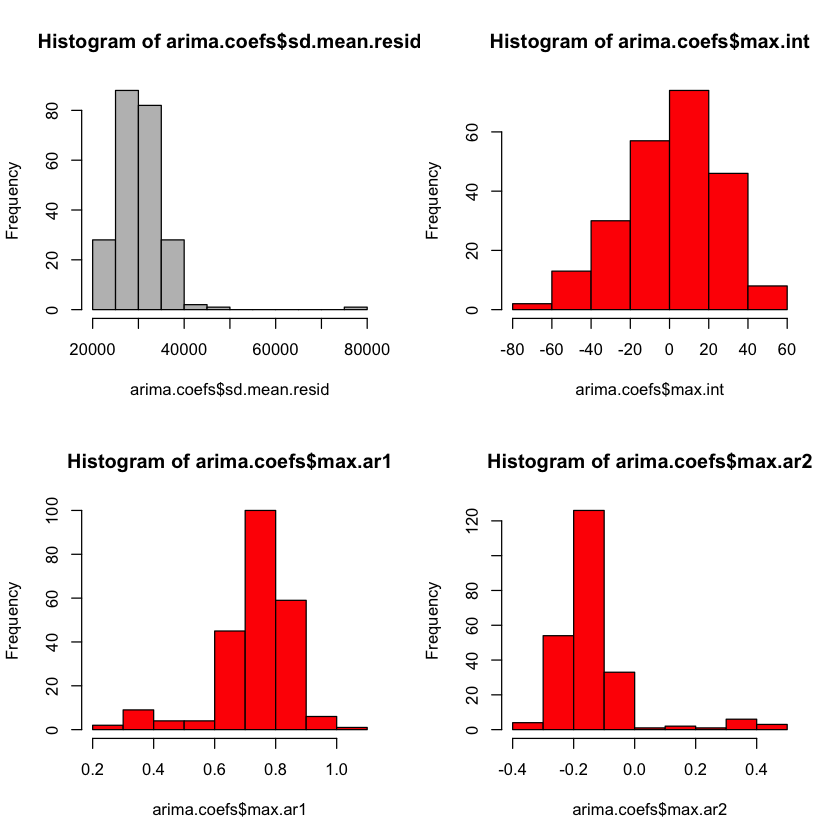

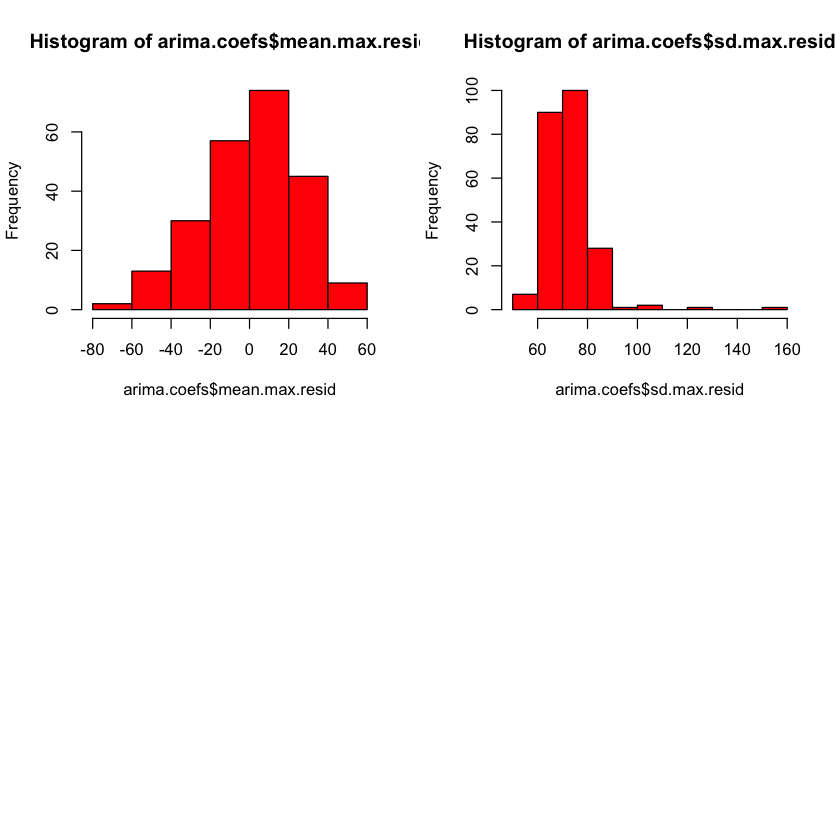

In [331]:
par(mfrow=c(2, 2))
hist(arima.coefs$min.int, col=4)
hist(arima.coefs$min.ar1, col=4)
hist(arima.coefs$mean.min.resid, col=4)
hist(arima.coefs$sd.min.resid, col=4)
hist(arima.coefs$mean.int, col='grey')
hist(arima.coefs$mean.ar1, col='grey')
hist(arima.coefs$mean.ar2, col='grey')
hist(arima.coefs$mean.mean.resid, col='grey')
hist(arima.coefs$sd.mean.resid, col='grey')
hist(arima.coefs$max.int, col=2)
hist(arima.coefs$max.ar1, col=2)
hist(arima.coefs$max.ar2, col=2)
hist(arima.coefs$mean.max.resid, col=2)
hist(arima.coefs$sd.max.resid, col=2)

In [332]:
MIN_INT <- median(arima.coefs$min.int, na.rm=T)
MIN_AR1 <- median(arima.coefs$min.ar1, na.rm=T)
MIN_MEAN_RESID <- median(arima.coefs$mean.min.resid)
MIN_SD_RESID <- median(arima.coefs$sd.min.resid)

MEAN_INT <- median(arima.coefs$mean.int, na.rm=T)
MEAN_AR1 <- median(arima.coefs$mean.ar1, na.rm=T)
MEAN_AR2 <- median(arima.coefs$mean.ar2, na.rm=T)
MEAN_MEAN_RESID <- median(arima.coefs$mean.mean.resid)
MEAN_SD_RESID <- median(arima.coefs$sd.mean.resid)

MAX_INT <- median(arima.coefs$max.int, na.rm=T)
MAX_AR1 <- median(arima.coefs$max.ar1, na.rm=T)
MAX_AR2 <- median(arima.coefs$max.ar2, na.rm=T)
MAX_MEAN_RESID <- median(arima.coefs$mean.max.resid)
MAX_SD_RESID <- median(arima.coefs$sd.max.resid)

In [333]:
min.int.mod <- lm(min.int ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3, 
                  data=arima.coefs)
min.int.mod <- step(min.int.mod, trace=0)
#summary(min.int.mod)

In [334]:
min.ar1.mod <- lm(min.ar1 ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3, 
                  data=arima.coefs)
min.ar1.mod <- step(min.ar1.mod, trace=0)
#summary(min.ar1.mod)

In [335]:
min.mean.resid.mod <- lm(mean.min.resid ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3, 
                  data=arima.coefs)
min.mean.resid.mod <- step(min.mean.resid.mod, trace=0)
#summary(min.mean.resid.mod)

In [336]:
min.sd.resid.mod <- lm(sd.min.resid ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3, 
                  data=arima.coefs)
min.sd.resid.mod <- step(min.sd.resid.mod, trace=0)
#summary(min.sd.resid.mod)

In [337]:
mean.int.mod <- lm(mean.int ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3,
                   data=arima.coefs)
mean.int.mod <- step(mean.int.mod, trace=0)
#summary(mean.int.mod)

In [338]:
mean.ar1.mod <- lm(mean.ar1 ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3, 
                   data=arima.coefs)
mean.ar1.mod <- step(mean.ar1.mod, trace=0)
#summary(mean.ar1.mod)

In [339]:
mean.ar2.mod <- lm(mean.ar2 ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3, 
                   data=arima.coefs)
mean.ar2.mod <- step(mean.ar2.mod, trace=0)
#summary(mean.ar2.mod)

In [340]:
mean.mean.resid.mod <- lm(mean.mean.resid ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3, 
                  data=arima.coefs)
mean.mean.resid.mod <- step(mean.mean.resid.mod, trace=0)
#summary(mean.mean.resid.mod)

In [341]:
mean.sd.resid.mod <- lm(sd.mean.resid ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3, 
                  data=arima.coefs)
mean.sd.resid.mod <- step(mean.sd.resid.mod, trace=0)
#summary(mean.sd.resid.mod)

In [342]:
max.int.mod <- lm(max.int ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3, 
                  data=arima.coefs)
max.int.mod <- step(max.int.mod, trace=0)
#summary(max.int.mod)

In [343]:
max.ar1.mod <- lm(max.ar1 ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3, 
                  data=arima.coefs)
max.ar1.mod <- step(max.ar1.mod, trace=0)
#summary(max.ar1.mod)

In [344]:
max.ar2.mod <- lm(max.ar2 ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3, 
                  data=arima.coefs)
max.ar2.mod <- step(max.ar2.mod, trace=0)
#summary(max.ar2.mod)

In [345]:
max.mean.resid.mod <- lm(mean.max.resid ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3, 
                  data=arima.coefs)
max.mean.resid.mod <- step(max.mean.resid.mod, trace=0)
#summary(max.mean.resid.mod)

In [346]:
max.sd.resid.mod <- lm(sd.max.resid ~ (
                    LATITUDE 
                    + LONGITUDE 
                    + ELEVATION 
                    + MEAN_PRECIP
                    + MIN_PRECIP
                    + MAX_PRECIP
                    + MEAN_TEMP
                    + MIN_MEANTEMP
                    + MAX_MEANTEMP)^3, 
                  data=arima.coefs)
max.sd.resid.mod <- step(max.sd.resid.mod, trace=0)
#summary(max.mean.resid.mod)

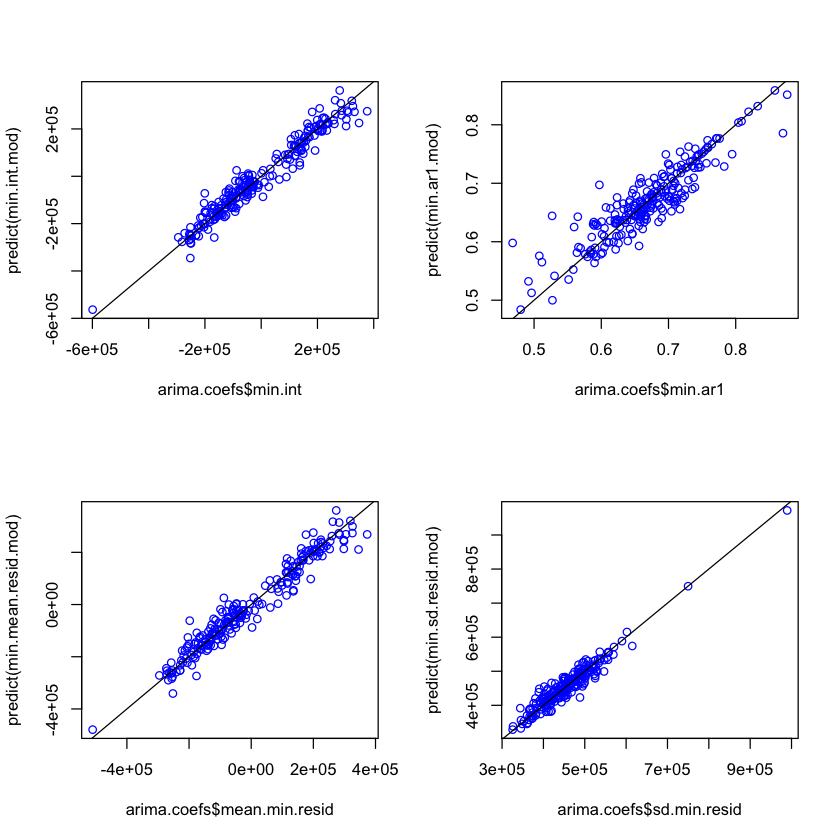

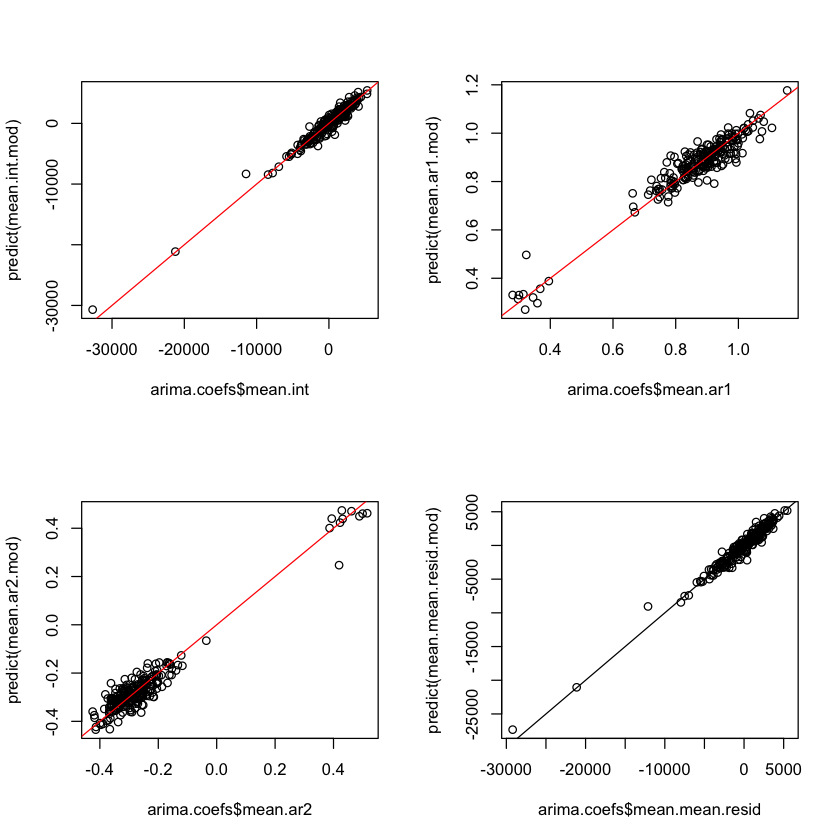

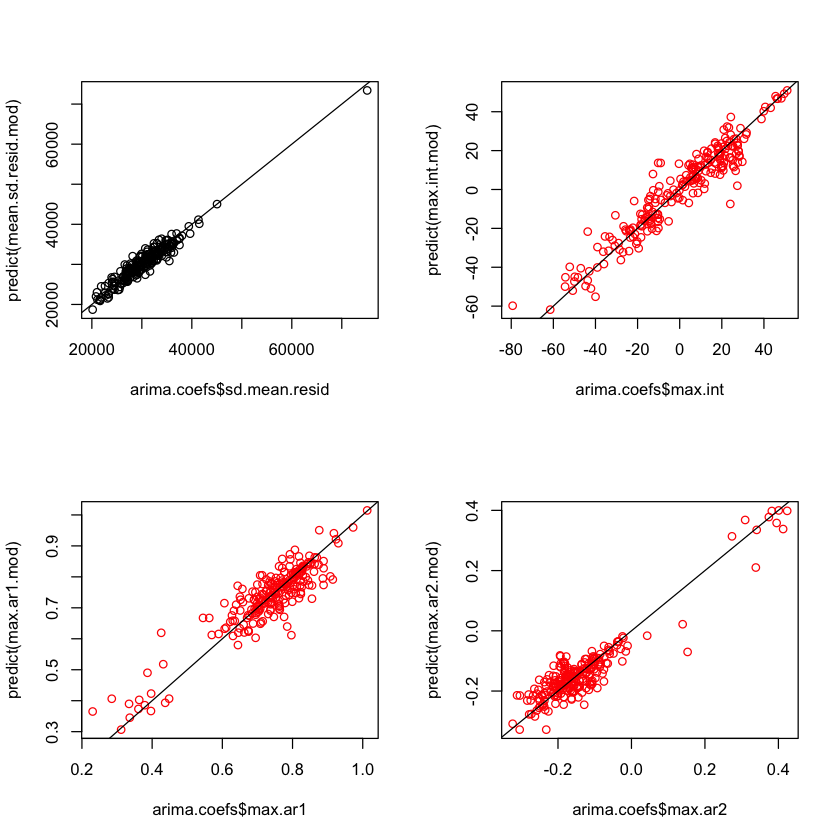

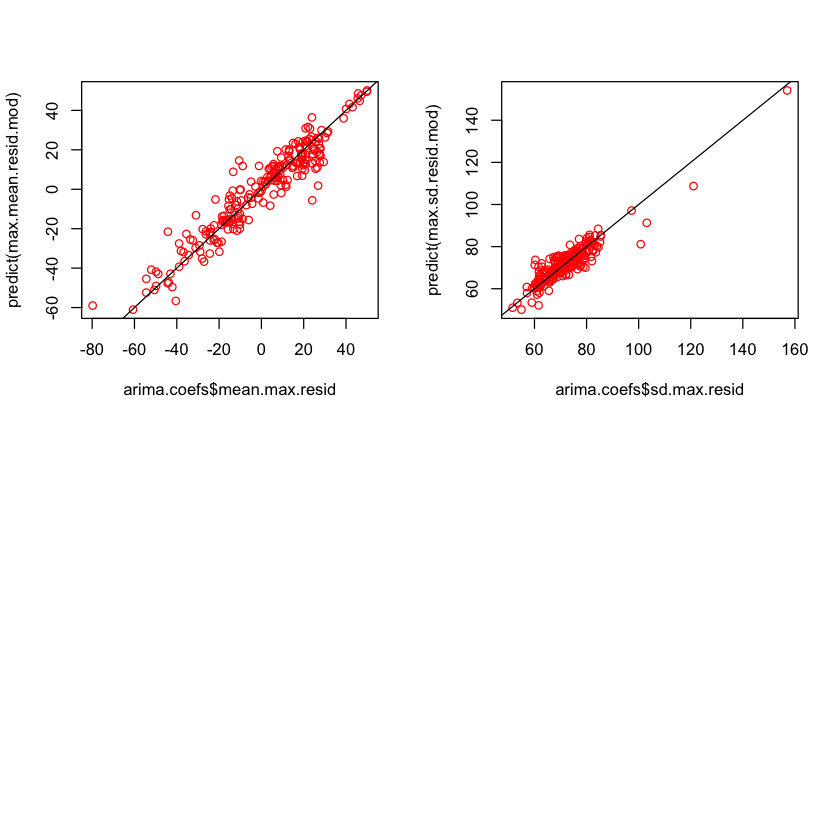

In [347]:
par(mfrow=c(2, 2))
plot(predict(min.int.mod) ~ arima.coefs$min.int, col=4)
abline(0, 1)
plot(predict(min.ar1.mod) ~ arima.coefs$min.ar1, col=4)
abline(0, 1)
plot(predict(min.mean.resid.mod) ~ arima.coefs$mean.min.resid, col=4)
abline(0, 1)
plot(predict(min.sd.resid.mod) ~ arima.coefs$sd.min.resid, col=4)
abline(0, 1)


plot(predict(mean.int.mod) ~ arima.coefs$mean.int)
abline(0, 1, col=2)
plot(predict(mean.ar1.mod) ~ arima.coefs$mean.ar1)
abline(0, 1, col=2)
plot(predict(mean.ar2.mod) ~ arima.coefs$mean.ar2)
abline(0, 1, col=2)
plot(predict(mean.mean.resid.mod) ~ arima.coefs$mean.mean.resid)
abline(0, 1)
plot(predict(mean.sd.resid.mod) ~ arima.coefs$sd.mean.resid)
abline(0, 1)

plot(predict(max.int.mod) ~ arima.coefs$max.int, col=2)
abline(0, 1)
plot(predict(max.ar1.mod) ~ arima.coefs$max.ar1, col=2)
abline(0, 1)
plot(predict(max.ar2.mod) ~ arima.coefs$max.ar2, col=2)
abline(0, 1)
plot(predict(max.mean.resid.mod) ~ arima.coefs$mean.max.resid, col=2)
abline(0, 1)
plot(predict(max.sd.resid.mod) ~ arima.coefs$sd.max.resid, col=2)
abline(0, 1)


# Predict pseudo daily from monthly

In [348]:
get.pseudo.residuals <- function(
    n, resid.mean, resid.sd, intercept, ar1, ar2=0) {
  pseudo.arima.error <- rnorm(n + 2, resid.mean, resid.sd)
  pseudo.resids <- numeric(n + 2)
  # rand seed for init 
  pseudo.resids[1:2] <- rnorm(2, resid.mean, resid.sd)
  for (t in 3:(n + 2)) {
    pseudo.resids[t] <- (intercept
                         + ar1*pseudo.resids[t - 1]
                         + ar2*pseudo.resids[t - 2]
                         + pseudo.arima.error[t])
  }
  pseudo.resids[-c(1:2)]    
}

In [362]:
SCALER <- 0.7
path <- paste(DATA_DIR, files[120], sep='')
data <- prep.data(path)
data$MEAN_PRECIP <- mean(data$monthly.precip, na.rm=T)
data$MIN_PRECIP <- min(data$monthly.precip, na.rm=T)
data$MAX_PRECIP <- max(data$monthly.precip, na.rm=T)
data$MEAN_TEMP <- mean(data$monthly.means, na.rm=T)
data$MIN_MEANTEMP <- min(data$monthly.means, na.rm=T)
data$MAX_MEANTEMP <- max(data$monthly.means, na.rm=T)

# fitted model
pred.mean <- predict(mean.temp.mod, newdata=data)
pred.min <- predict(min.temp.mod, newdata=data)
pred.max <- predict(max.temp.mod, newdata=data)

min.int <- MIN_INT #predict(min.int.mod, newdata=data[1, ])
min.ar1 <- MIN_AR1 #predict(min.ar1.mod, newdata=data[1, ])
mean.int <- MEAN_INT #predict(mean.int.mod, newdata=data[1, ])
mean.ar1 <- MEAN_AR1 #predict(mean.ar1.mod, newdata=data[1, ])
mean.ar2 <- MEAN_AR2 #predict(mean.ar2.mod, newdata=data[1, ])
max.int <- MAX_INT #predict(max.int.mod, newdata=data[1, ])
max.ar1 <- MAX_AR1 #predict(max.ar1.mod, newdata=data[1, ])
max.ar2 <- MAX_AR2 #predict(max.ar2.mod, newdata=data[1, ])
min.mean.resid <- MIN_MEAN_RESID #predict(min.mean.resid.mod, newdata=data[1, ])
min.sd.resid <- MIN_SD_RESID #predict(min.sd.resid.mod, newdata=data[1, ])
mean.mean.resid <- MEAN_MEAN_RESID #predict(mean.mean.resid.mod, newdata=data[1, ])
mean.sd.resid <- MEAN_SD_RESID #predict(mean.sd.resid.mod, newdata=data[1, ])
max.mean.resid <- MAX_MEAN_RESID #predict(max.mean.resid.mod, newdata=data[1, ])
max.sd.resid <- MAX_SD_RESID #predict(max.sd.resid.mod, newdata=data[1, ])

# create pseudo residuals
mean.pseudo <- get.pseudo.residuals(
  n=length(pred.mean), 
  resid.mean=mean.mean.resid, 
  resid.sd=mean.sd.resid, 
  intercept=mean.int, 
  ar1=mean.ar1, 
  ar2=mean.ar2) * SCALER
min.pseudo <- get.pseudo.residuals(
  n=length(pred.min), 
  resid.mean=min.mean.resid, 
  resid.sd=min.sd.resid, 
  intercept=min.int, 
  ar1=min.ar1) * SCALER
max.pseudo <- get.pseudo.residuals(
  n=length(pred.max), 
  resid.mean=max.mean.resid, 
  resid.sd=max.sd.resid, 
  intercept=max.int, 
  ar1=max.ar1, 
  ar2=max.ar2) * SCALER

# pseudo-daily predictions
pred.daily.mean <- pred.mean + mean.pseudo
pred.mean <- reverse.transform(pred.mean, lambda.avg)
pred.daily.mean <- reverse.transform(pred.daily.mean, lambda.avg)

pred.daily.min <- pred.min + min.pseudo
pred.min <- reverse.transform(pred.min, lambda.min)
pred.daily.min <- reverse.transform(pred.daily.min, lambda.min)

pred.daily.max <- pred.max + max.pseudo
pred.max <- reverse.transform(pred.max, lambda.max)
pred.daily.max <- reverse.transform(pred.daily.max, lambda.max)

In [363]:
head(data)

STATION     NAME                     LATITUDE LONGITUDE ELEVATION DATE      
1 USS0010J10S LAKEFORK NUMBER 1, UT US 40.6     -110.43   3174.5    2016-01-01
2 USS0010J10S LAKEFORK NUMBER 1, UT US 40.6     -110.43   3174.5    2016-01-02
3 USS0010J10S LAKEFORK NUMBER 1, UT US 40.6     -110.43   3174.5    2016-01-03
4 USS0010J10S LAKEFORK NUMBER 1, UT US 40.6     -110.43   3174.5    2016-01-04
5 USS0010J10S LAKEFORK NUMBER 1, UT US 40.6     -110.43   3174.5    2016-01-05
6 USS0010J10S LAKEFORK NUMBER 1, UT US 40.6     -110.43   3174.5    2016-01-06
  PRCP TAVG  TMAX TMIN  ⋯ monthly.precip tmin    tmax      tavg     MEAN_PRECIP
1 0.0  -18.2 -6.1 -26.9 ⋯ 47.8           1165945  895.0387 148867.3 61.13224   
2 2.5  -11.1  0.1 -21.0 ⋯ 47.8           1535846  991.5186 190299.4 61.13224   
3 2.5   -7.1  2.9 -15.1 ⋯ 47.8           1983325 1036.2935 216682.4 61.13224   
4 2.5   -5.1 -0.1  -9.8 ⋯ 47.8           2458979  988.3488 230734.6 61.13224   
5 2.5   -6.0 -3.9  -7.6 ⋯ 47.8           2678595  928.8494 224338.9 61.13224   
6 2.5   -5.7 -2.1  -7.2 ⋯ 47.8           2719988  956.8608 226457.6 61.13224   
  MIN_PRECIP MAX_PRECIP MEAN_TEMP MIN_MEANTEMP MAX_MEANTEMP
1 15.2       152.3      0.9923497 -9.193548    11.41935    
2 15.2       152.3      0.9923497 -9.193548    11.41935    
3 15.2       152.3      0.9923497 -9.193548    11.41935    
4 15.2       152.3      0.9923497 -9.193548    11.41935    
5 15.2       152.3      0.9923497 -9.193548    11.41935    
6 15.2       152.3      0.9923497 -9.193548    11.41935

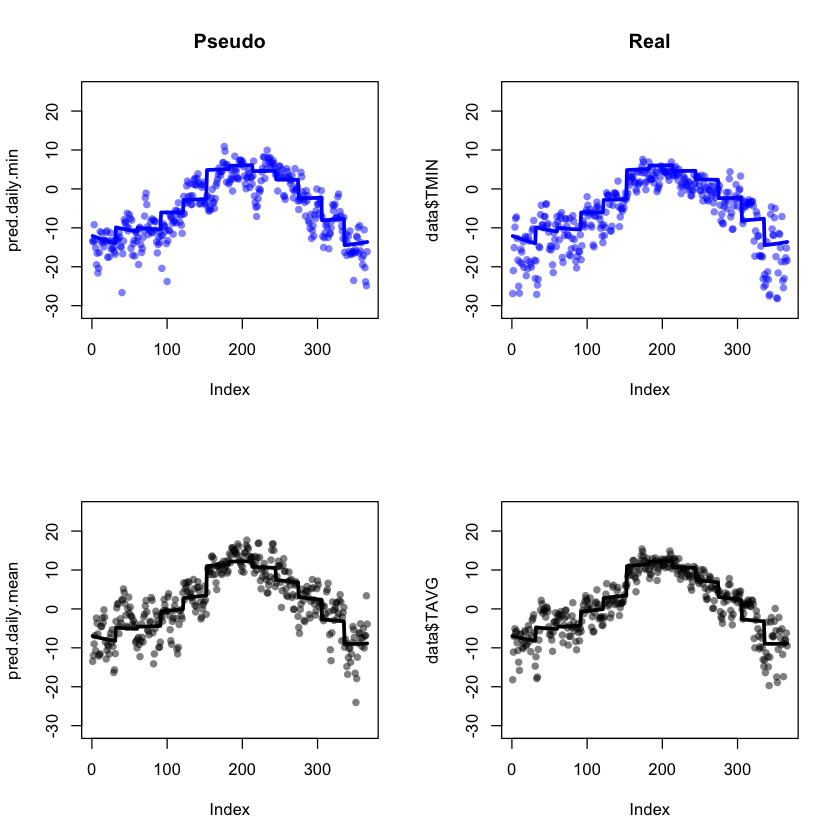

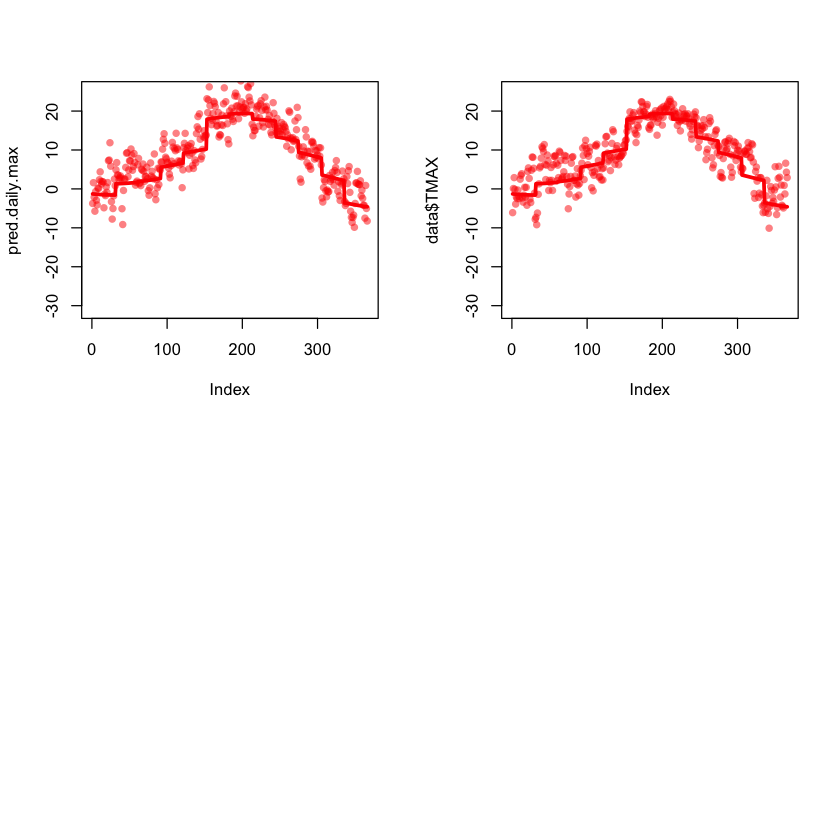

In [364]:
par(mfrow=c(2, 2))
# pseudo
plot(pred.daily.min, 
     pch=16, 
     col=rgb(0, 0, 1, 0.5), 
     ylim=1.1 * range(c(data$TMIN, data$TMAX)),
     main='Pseudo')
lines(pred.min, lwd=3, col=4)

# real
plot(data$TMIN, 
     pch=16, 
     col=rgb(0, 0, 1, 0.5), 
     ylim=1.1 * range(c(data$TMIN, data$TMAX)),
     main='Real')
lines(pred.min, lwd=3, col=4)

# pseudo
plot(pred.daily.mean, 
     pch=16, 
     col=rgb(0, 0, 0, 0.5), 
     ylim=1.1 * range(c(data$TMIN, data$TMAX)))
lines(pred.mean, lwd=3)

# real
plot(data$TAVG, 
     pch=16, 
     col=rgb(0, 0, 0, 0.5), 
     ylim=1.1 * range(c(data$TMIN, data$TMAX)))
lines(pred.mean, lwd=3)

# pseudo
plot(pred.daily.max, 
     pch=16, 
     col=rgb(1, 0, 0, 0.5), 
     ylim=1.1 * range(c(data$TMIN, data$TMAX)))
lines(pred.max, lwd=3, col=2)

# real
plot(data$TMAX, 
     pch=16, 
     col=rgb(1, 0, 0, 0.5), 
     ylim=1.1 * range(c(data$TMIN, data$TMAX)))
lines(pred.max, lwd=3, col=2)